In [1]:
import matplotlib.pyplot as mpl
import matplotlib
import pandas as pd
import statsmodels.api as sm

In [2]:
import gzip as gz
from frommle2.core.logger import logger
from datetime import datetime,timedelta
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d

cconv=(1-100/60)
swopfac={"E":+1,"W":-1,"N":1,"S":-1}
def parseDeg(deg,EWNS):
    decdeg=deg/60+cconv*int(deg/100)
    return swopfac[EWNS]*decdeg

def smoothDegrees(degarray,timev,irec=0):
        """ Smooths degree array whcih only have degree resolution to a version which varies more smoothly (i.e. no jumps)"""
        
        if len(degarray) == 1:
            #Corner case just return original value
            return degarray


        ddif=np.diff(degarray)

        if np.count_nonzero(ddif) == 0:
            #no need to interpolate in this case as all values are the same
            return degarray

        
        if irec > 1:
            assert("This function is not supposed to be called with a recursion depth more than 1)")
            #Possibly split into contigous sections (i.e. crossing  0-360 border or jumping in time)
        dsections=np.argwhere(np.logical_or((np.abs(ddif) > 180.0), (np.diff(timev) > np.timedelta64(30,'s'))))  
        if dsections.size != 0:
            degsmth=np.full([len(degarray)],np.nan)
            for ist,iend in zip(np.insert(dsections+1,0,0),np.append(dsections+1,len(degarray))):
                #call this function for the sections (it shouldn;t execute this if part)
                degsmth[ist:iend]=smoothDegrees(degarray[ist:iend],timev[ist:iend],irec=irec+1)
        else:
            
            #compute for the contiguous section
            #detect the jumps (and add the first and final index) value
            ijumps=np.insert(np.append(np.argwhere(ddif != 0).squeeze()+1,len(degarray)),0,0)

            #what are half the interval lengths between the jump locations (we need to shift the interpolant input by this)
            iintHalfDistance=np.diff(ijumps)/2
            #create the support points for the interpolant
            isup=ijumps[0:-1]+iintHalfDistance
            degsup=degarray[ijumps[0:-1]]
            inonnan=~np.isnan(degarray[ijumps[0:-1]])
            #create an interpolant based on the values where a jump was detected
            iinterp=interp1d(isup[inonnan],degsup[inonnan],kind='linear',fill_value="extrapolate")
            degsmth=iinterp([float(i) for i in range(len(degarray))])
            

            degsmth[np.isnan(degsmth)]=np.nan #refill original nan values with nans again
        
        return degsmth

def parseGNRMC(ln):
    
    spl=ln.split(",")
    if spl[2] == "V":
        return {}
    hr=int(spl[1][0:2])
    mn=int(spl[1][2:4])
    sec=float(spl[1][4:])
    date=datetime.strptime(spl[9],"%d%m%y")
    dt={"time":date+timedelta(hours=hr,minutes=mn,seconds=sec)}
    #parse weird DDDMM.MMMMM format
    dt["lat"]=parseDeg(float(spl[3]),spl[4])
    dt["lon"]=parseDeg(float(spl[5]),spl[6])
    return dt

def parseGNGSV(ln):
    #split line without considering the checksum at the end
    spl=ln[0:-4].split(",")
    dt={}
    system=spl[0][1:3].replace('GL','GLONASS').replace('GP','GPS')
    #loop over available satellite prn's
    for i in range(4,len(spl),4):
        try:
            prn=f"PRN{spl[i]}"
            elev=float(spl[i+1])
            az=float(spl[i+2])
            snr=float(spl[i+3])
        except ValueError:
            #It may be possible that ,,, entries occur, so we'll just ignore those
            continue

        dt[prn]={"system":system,"elev":elev,"az":az,"snr":snr}
    
    return dt   


dispatchParse={"$GPRMC":parseGNRMC,"$GPGSV":parseGNGSV,"$GNRMC":parseGNRMC,"$GLGSV":parseGNGSV}

def readnmea(fidorfile):
    """Parses a nmea file/stream and puts the output in a pandas dataframe"""
    if type(fidorfile) == str:
        if fidorfile.endswith('.gz'):
            fid=gz.open(fidorfile,'rt')
        else:
            fid=open(fidorfile,'rt')
    else:
        fid=fidorfile



    #loop over the buffer and parse messages as we go
    nmeacycle={}
    nmeadata=[]
    for ln in fid:
        if ln.startswith("$"):
            try:
                nmeacycle.update(dispatchParse[ln[0:6]](ln))
                #possibly append this cycle data to nmeadata when a time tag is present
                if "time" in nmeacycle and (sum(k.startswith("PRN") for k in nmeacycle.keys()) > 0):

                    basedict={k:v for k,v in nmeacycle.items() if not k.startswith("PRN")}

                    #unwrap the different PRN's into separate rows
                    for ky,val in nmeacycle.items():
                        if ky.startswith("PRN"):
                            nmeadata.append({**basedict,"PRN":int(ky[3:]),**val})
                    #reset nmeacycle dict
                    nmeacycle={}
            except KeyError:
                continue
                logger.warning(f"Skipping unknown NMEA message {ln[0:6]}")

    #create a dataframe and set multiindex
    df=pd.DataFrame(nmeadata)
    #We wan to get rid of rows which don;t have a elevation of azimuth in them
    # df.dropna(subset=["elev","az"],inplace=True)
    

    #since the resolution of the elevatio, and azimuthn is only on discrete degrees, let's create smoothed versions (better for plotting etc)
    # Furthermore, we also want to identify the different ascending/descending segment, even/oddly numbered repspectively so we can select of those too
    df["elevsmth"]=np.nan 
    df["azsmth"]=np.nan 
    df["segment"]=-1
    for name,grp in df.groupby("PRN"):
        time=grp.time.to_numpy()
        for dvi,dvo in [("elev","elevsmth"),("az","azsmth")]:
            dsmooth=smoothDegrees(grp[dvi].to_numpy(),time)
            #put the stuff back in the dataframe
            df.loc[grp.index,dvo]=dsmooth


            if dvi == "elev" and len(dsmooth) > 2:
                #also figure out the valid iascending (will be even numbered, descending will be oddly numbered) segments per PRN
                pdif=(np.diff(dsmooth)>0).astype(float)
                segment=np.insert(np.cumsum(np.abs(np.diff(pdif))),0,[0,0]).astype(int)
                if pdif[0] == 0.0:
                    #starts with a descending node
                    #make sure it's oddly numbered
                    segment=segment+1

                df.loc[grp.index,"segment"]=segment


    return df.set_index(["time","system","PRN","segment"])

In [3]:
filename ="../NMEA_Prsing/NMEA_GNSSR2/2022-03-26-gnssr2.gz"
DF = readnmea(filename)

In [4]:
DF.head(10)

lat       lon  elev     az  \
time                system PRN segment                                     
2022-03-26 00:00:02 GPS    4   1        52.251285  5.690115  77.0  118.0   
                           9   0        52.251285  5.690115  54.0  214.0   
                           6   0        52.251285  5.690115  53.0  296.0   
                           3   1        52.251285  5.690115  50.0   91.0   
2022-03-26 00:00:03 GPS    19  1        52.251285  5.690115  31.0  247.0   
                           49  1        52.251285  5.690115  30.0  180.0   
                           17  1        52.251285  5.690115  22.0  229.0   
                           1   1        52.251285  5.690115  14.0  149.0   
                           31  1        52.251285  5.690115  14.0   34.0   
                           2   0        52.251285  5.690115  11.0  317.0   

                                         snr   elevsmth      azsmth  
time                system PRN segment                               
2022-03-26 00:00:02 GPS    4   1        34.0  77.603306  118.307692  
                           9   0        32.0  53.888889  213.630189  
                           6   0        33.0  52.480000  296.076923  
                           3   1        36.0  50.500000   90.671429  
2022-03-26 00:00:03 GPS    19  1        36.0  31.094340  247.547170  
                           49  1        34.0  30.000000  180.000000  
                           17  1        27.0  22.096154  229.368421  
                           1   1        29.0  14.040000  148.826389  
                           31  1        32.0  14.127273   34.563636  
                           2   0        32.0  10.957447  317.455939

# Dividing Between GPS and GLONASS signals #

In [5]:
DF_GPS = DF.xs('GPS', level='system')
DF_GLONASS = DF.xs('GLONASS', level='system')

### GPS Signals ###

In [6]:
DF_GPS.tail()

lat       lon  elev     az   snr  \
time                PRN segment                                          
2022-03-26 23:59:58 31  13       52.25128  5.690098  13.0   33.0  24.0   
                    1   17       52.25128  5.690098  12.0  150.0  31.0   
                    2   10       52.25128  5.690098  12.0  317.0  20.0   
                    26  13       52.25128  5.690098   1.0   68.0  17.0   
                    25  11       52.25128  5.690098   1.0  350.0  18.0   

                                  elevsmth      azsmth  
time                PRN segment                         
2022-03-26 23:59:58 31  13       12.400000   32.769231  
                    1   17       11.553191  150.177966  
                    2   10       12.633803  317.000000  
                    26  13        1.000000   68.000000  
                    25  11        0.880597  349.529412

**Filter The Azimuth**

In [7]:
DF_GPSaz = DF_GPS[DF_GPS['azsmth'].between(0, 120, inclusive=False)]
DF_GPSaz

/tmp/ipykernel_3319/3142924445.py:1: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  DF_GPSaz = DF_GPS[DF_GPS['azsmth'].between(0, 120, inclusive=False)]


lat       lon  elev     az   snr  \
time                PRN segment                                           
2022-03-26 00:00:02 4   1        52.251285  5.690115  77.0  118.0  34.0   
                    3   1        52.251285  5.690115  50.0   91.0  36.0   
2022-03-26 00:00:03 31  1        52.251285  5.690115  14.0   34.0  32.0   
2022-03-26 00:00:07 4   1        52.251283  5.690113  77.0  118.0  35.0   
                    3   1        52.251283  5.690113  50.0   91.0  34.0   
...                                    ...       ...   ...    ...   ...   
2022-03-26 23:59:53 31  13       52.251280  5.690102  13.0   33.0  24.0   
2022-03-26 23:59:57 4   22       52.251282  5.690100  77.0  110.0  27.0   
                    3   11       52.251282  5.690100  49.0   92.0  37.0   
2022-03-26 23:59:58 31  13       52.251280  5.690098  13.0   33.0  24.0   
                    26  13       52.251280  5.690098   1.0   68.0  17.0   

                                  elevsmth      azsmth  
time                PRN segment                         
2022-03-26 00:00:02 4   1        77.603306  118.307692  
                    3   1        50.500000   90.671429  
2022-03-26 00:00:03 31  1        14.127273   34.563636  
2022-03-26 00:00:07 4   1        77.586777  118.000000  
                    3   1        50.456522   90.700000  
...                                    ...         ...  
2022-03-26 23:59:53 31  13       12.430769   32.800000  
2022-03-26 23:59:57 4   22       77.687764  108.173913  
                    3   11       48.700000   92.300000  
2022-03-26 23:59:58 31  13       12.400000   32.769231  
                    26  13        1.000000   68.000000  

[66297 rows x 7 columns]

**Filter The Elevation Angle**

In [8]:
DF_GPSel = DF_GPSaz[DF_GPS['elevsmth'].between(20, 70, inclusive=False)]
DF_GPSel

/tmp/ipykernel_3319/1623412729.py:1: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  DF_GPSel = DF_GPSaz[DF_GPS['elevsmth'].between(20, 70, inclusive=False)]
/tmp/ipykernel_3319/1623412729.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  DF_GPSel = DF_GPSaz[DF_GPS['elevsmth'].between(20, 70, inclusive=False)]


lat       lon  elev    az   snr  \
time                PRN segment                                          
2022-03-26 00:00:02 3   1        52.251285  5.690115  50.0  91.0  36.0   
2022-03-26 00:00:07 3   1        52.251283  5.690113  50.0  91.0  34.0   
2022-03-26 00:00:12 3   1        52.251283  5.690113  50.0  91.0  32.0   
2022-03-26 00:00:22 3   1        52.251282  5.690120  50.0  91.0  29.0   
2022-03-26 00:00:27 3   1        52.251282  5.690120  50.0  91.0  29.0   
...                                    ...       ...   ...   ...   ...   
2022-03-26 23:59:37 3   11       52.251278  5.690097  49.0  92.0  38.0   
2022-03-26 23:59:42 3   11       52.251280  5.690097  49.0  92.0  36.0   
2022-03-26 23:59:47 3   11       52.251280  5.690097  49.0  92.0  32.0   
2022-03-26 23:59:52 3   11       52.251280  5.690102  49.0  92.0  33.0   
2022-03-26 23:59:57 3   11       52.251282  5.690100  49.0  92.0  37.0   

                                  elevsmth     azsmth  
time                PRN segment                        
2022-03-26 00:00:02 3   1        50.500000  90.671429  
2022-03-26 00:00:07 3   1        50.456522  90.700000  
2022-03-26 00:00:12 3   1        50.413043  90.728571  
2022-03-26 00:00:22 3   1        50.369565  90.757143  
2022-03-26 00:00:27 3   1        50.326087  90.785714  
...                                    ...        ...  
2022-03-26 23:59:37 3   11       48.814286  92.185714  
2022-03-26 23:59:42 3   11       48.785714  92.214286  
2022-03-26 23:59:47 3   11       48.757143  92.242857  
2022-03-26 23:59:52 3   11       48.728571  92.271429  
2022-03-26 23:59:57 3   11       48.700000  92.300000  

[31867 rows x 7 columns]

**Get the list of PRN based on the filtered azimuth & Elevation Angle**

In [9]:
DF_GPSp= DF_GPSel.index.get_level_values('PRN')
#print(DF_GPSp)
PRN_Code = []
for code in DF_GPSp:
    if code not in PRN_Code:
        PRN_Code.append(code)
print(PRN_Code)

[3, 4, 9, 7, 30, 14, 17, 19, 6, 2, 12, 25, 29, 5, 18, 23, 10, 32, 22, 21, 31]


time  segment        lat       lon  elev    az   snr  \
0     2022-03-26 00:00:02        1  52.251285  5.690115  50.0  91.0  36.0   
1     2022-03-26 00:00:07        1  52.251283  5.690113  50.0  91.0  34.0   
2     2022-03-26 00:00:12        1  52.251283  5.690113  50.0  91.0  32.0   
3     2022-03-26 00:00:22        1  52.251282  5.690120  50.0  91.0  29.0   
4     2022-03-26 00:00:27        1  52.251282  5.690120  50.0  91.0  29.0   
...                   ...      ...        ...       ...   ...   ...   ...   
31862 2022-03-26 23:59:37       11  52.251278  5.690097  49.0  92.0  38.0   
31863 2022-03-26 23:59:42       11  52.251280  5.690097  49.0  92.0  36.0   
31864 2022-03-26 23:59:47       11  52.251280  5.690097  49.0  92.0  32.0   
31865 2022-03-26 23:59:52       11  52.251280  5.690102  49.0  92.0  33.0   
31866 2022-03-26 23:59:57       11  52.251282  5.690100  49.0  92.0  37.0   

        elevsmth     azsmth  
0      50.500000  90.671429  
1      50.456522  90.700000  
2      50.413043  90.728571  
3      50.369565  90.757143  
4      50.326087  90.785714  
...          ...        ...  
31862  48.814286  92.185714  
31863  48.785714  92.214286  
31864  48.757143  92.242857  
31865  48.728571  92.271429  
31866  48.700000  92.300000  

[31867 rows x 9 columns]

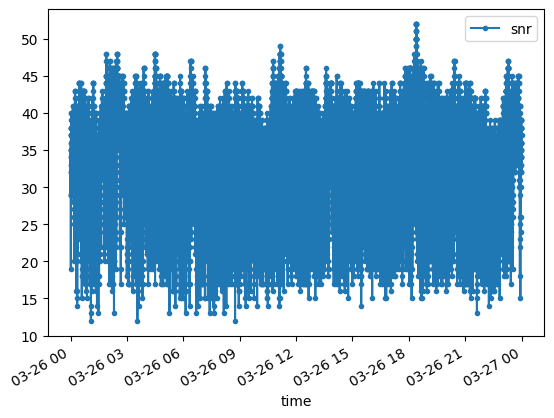

In [10]:
DF_GGG = DF_GPSel.droplevel('PRN', axis=0).reset_index()
DF_GGG.plot(x='time',y='snr',marker='.')
DF_GGG

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from collections import defaultdict

**PRN 3**

In [12]:
DF_GPSF3 = DF_GPSel.xs(3,level='PRN')
#print(DF_GPSF3)
DF_GPSazmax = DF_GPSF3['azsmth'].max()
DF_GPSazmin = DF_GPSF3['azsmth'].min()
print(DF_GPSazmin,',', DF_GPSazmax)

DF_GPSelmax = DF_GPSF3['elevsmth'].max()
DF_GPSelmin = DF_GPSF3['elevsmth'].min()
print(DF_GPSelmin,',', DF_GPSelmax)


DF_GPSFValue= DF_GPSF3.index.get_level_values('segment')
#print(DF_GPSFValue)
segment = []
for element in DF_GPSFValue:
    if element not in segment:
        segment.append(element)
print(segment)

74.04166666666667 , 111.22105263157894
20.028169014084508 , 69.97222222222223
[1, 11]


In [13]:
DF_GPSF3

lat       lon  elev    az   snr   elevsmth  \
time                segment                                                     
2022-03-26 00:00:02 1        52.251285  5.690115  50.0  91.0  36.0  50.500000   
2022-03-26 00:00:07 1        52.251283  5.690113  50.0  91.0  34.0  50.456522   
2022-03-26 00:00:12 1        52.251283  5.690113  50.0  91.0  32.0  50.413043   
2022-03-26 00:00:22 1        52.251282  5.690120  50.0  91.0  29.0  50.369565   
2022-03-26 00:00:27 1        52.251282  5.690120  50.0  91.0  29.0  50.326087   
...                                ...       ...   ...   ...   ...        ...   
2022-03-26 23:59:37 11       52.251278  5.690097  49.0  92.0  38.0  48.814286   
2022-03-26 23:59:42 11       52.251280  5.690097  49.0  92.0  36.0  48.785714   
2022-03-26 23:59:47 11       52.251280  5.690097  49.0  92.0  32.0  48.757143   
2022-03-26 23:59:52 11       52.251280  5.690102  49.0  92.0  33.0  48.728571   
2022-03-26 23:59:57 11       52.251282  5.690100  49.0  92.0  37.0  48.700000   

                                azsmth  
time                segment             
2022-03-26 00:00:02 1        90.671429  
2022-03-26 00:00:07 1        90.700000  
2022-03-26 00:00:12 1        90.728571  
2022-03-26 00:00:22 1        90.757143  
2022-03-26 00:00:27 1        90.785714  
...                                ...  
2022-03-26 23:59:37 11       92.185714  
2022-03-26 23:59:42 11       92.214286  
2022-03-26 23:59:47 11       92.242857  
2022-03-26 23:59:52 11       92.271429  
2022-03-26 23:59:57 11       92.300000  

[1491 rows x 7 columns]

**PRN 3 Segment 1**

In [14]:
from statistics import median
GPSF_segment1_3=DF_GPSF3.xs(1,level='segment').reset_index()
print(GPSF_segment1_3['time'])
# timestamps = GPSF_segment1_3['time']
# median(timestamps)

0     2022-03-26 00:00:02
1     2022-03-26 00:00:07
2     2022-03-26 00:00:12
3     2022-03-26 00:00:22
4     2022-03-26 00:00:27
              ...        
881   2022-03-26 01:14:08
882   2022-03-26 01:14:13
883   2022-03-26 01:14:18
884   2022-03-26 01:14:23
885   2022-03-26 01:14:28
Name: time, Length: 886, dtype: datetime64[ns]


**Mean/0 order polynomial**

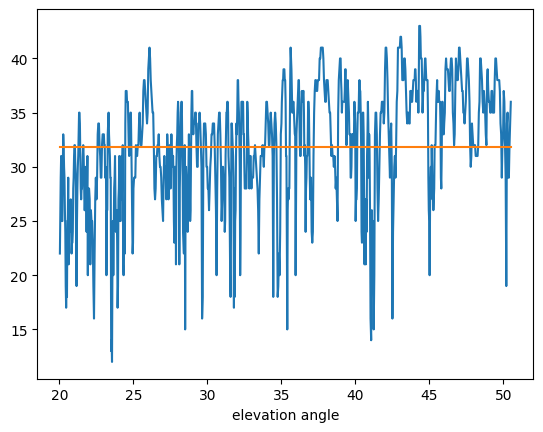

[31.82054176]
[[0.]]


In [15]:
x3=GPSF_segment1_3[['elevsmth']].values
y3=GPSF_segment1_3[['snr']].values
# y3=10**(y3/20)
x0=np.median(x3)

pf3 = PolynomialFeatures(degree=0)
Xp3 = pf3.fit_transform (x3-x0)
md3 = LinearRegression()

md3.fit(Xp3, y3)
trendp3 = md3.predict(Xp3)

mpl.plot(x3, y3)
mpl.plot(x3, trendp3)
# mpl.legend(['SNR', 'SNR mean = 77.55'])
# mpl.ylabel("volt/volt")
mpl.xlabel('elevation angle')
#mpl.savefig('mean.png', dpi=2000)
mpl.show()
print (md3.intercept_)
print (md3.coef_)

**2 order polynomial**

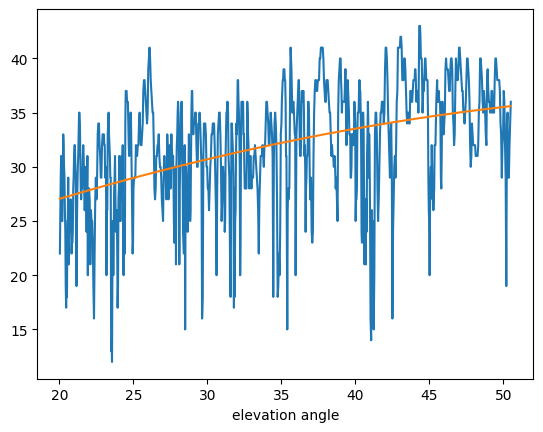

[32.16008532]
[[ 0.          0.28412934 -0.00413153]]


In [16]:
pf3 = PolynomialFeatures(degree=2)
x0=np.median(x3)
Xp3 = pf3.fit_transform(x3-x0)
md3 = LinearRegression()

md3.fit(Xp3, y3)
trendp3 = md3.predict(Xp3)

mpl.plot(x3, y3)
mpl.plot(x3, trendp3)
# mpl.legend(['data', 'polynomial trend'])
# mpl.legend(['SNR', 'Polynomial trend = $-0.0045X^2$ + $2.55X$ + 77.47'])
# mpl.ylabel("volt/volt")
mpl.xlabel('elevation angle')
# mpl.savefig('polynomial.png', dpi=2000)
mpl.show()
print (md3.intercept_)
print (md3.coef_)

**PRN 3 Segment 11**

In [17]:
GPSF_segment11_3=DF_GPSF3.xs(11,level='segment').reset_index()
print(GPSF_segment11_3['time'])
# timestamps = GPSF_segment11_3['time']
# median(timestamps)

0     2022-03-26 23:09:37
1     2022-03-26 23:09:42
2     2022-03-26 23:09:47
3     2022-03-26 23:09:52
4     2022-03-26 23:09:57
              ...        
600   2022-03-26 23:59:37
601   2022-03-26 23:59:42
602   2022-03-26 23:59:47
603   2022-03-26 23:59:52
604   2022-03-26 23:59:57
Name: time, Length: 605, dtype: datetime64[ns]


**Mean/0 order polynomial**

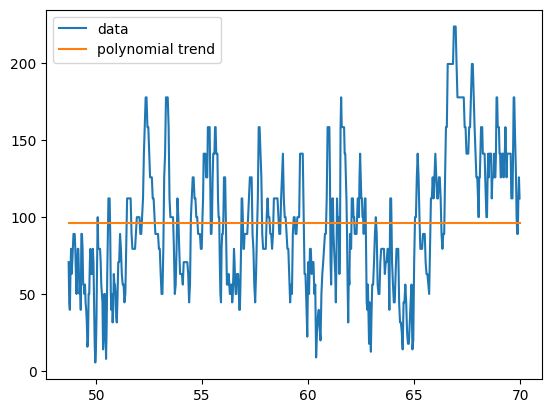

[96.28712064]


In [18]:
x3=GPSF_segment11_3[['elevsmth']].values
y3=GPSF_segment11_3[['snr']].values
y3=10**(y3/20)
x0=np.median(x3)

pf3 = PolynomialFeatures(degree=0)
Xp3 = pf3.fit_transform(x3)
md3 = LinearRegression()

md3.fit(Xp3, y3)
trendp3 = md3.predict(Xp3)

mpl.plot(x3, y3)
mpl.plot(x3, trendp3)
mpl.legend(['data', 'polynomial trend'])
mpl.show()
print (md3.intercept_)

**2 order polynomial**

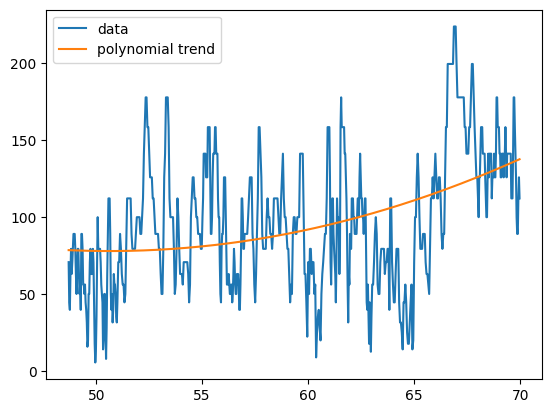

[89.91588497]


In [19]:
pf3 = PolynomialFeatures(degree=2)
Xp3 = pf3.fit_transform(x3-x0)
md3 = LinearRegression()

md3.fit(Xp3, y3)
trendp3 = md3.predict(Xp3)

mpl.plot(x3, y3)
mpl.plot(x3, trendp3)
mpl.legend(['data', 'polynomial trend'])
mpl.show()
print (md3.intercept_)

**PRN4**

In [20]:
DF_GPSF4 = DF_GPSel.xs(4,level='PRN')
#print(DF_GPSF4)
DF_GPSazmax = DF_GPSF4['azsmth'].max()
DF_GPSazmin = DF_GPSF4['azsmth'].min()
print(DF_GPSazmin,',', DF_GPSazmax)

DF_GPSelmax = DF_GPSF4['elevsmth'].max()
DF_GPSelmin = DF_GPSF4['elevsmth'].min()
print(DF_GPSelmin,',', DF_GPSelmax)


DF_GPSFValue= DF_GPSF4.index.get_level_values('segment')
#print(DF_GPS4Value)
segment = []
for element in DF_GPSFValue:
    if element not in segment:
        segment.append(element)
print(segment)

65.0 , 76.95833333333333
20.028169014084508 , 69.97222222222223
[1]


**PRN 4 Segment 1**

In [21]:
GPSF_segment1_4=DF_GPSF4.xs(1,level='segment').reset_index()
print(GPSF_segment1_4['time'])
# timestamps = GPSF_segment1_4['time']
# median(timestamps)

0      2022-03-26 00:27:02
1      2022-03-26 00:27:07
2      2022-03-26 00:27:12
3      2022-03-26 00:27:17
4      2022-03-26 00:27:22
               ...        
1417   2022-03-26 02:25:33
1418   2022-03-26 02:25:38
1419   2022-03-26 02:25:43
1420   2022-03-26 02:25:48
1421   2022-03-26 02:25:53
Name: time, Length: 1422, dtype: datetime64[ns]


**mean/0 order polynomial**

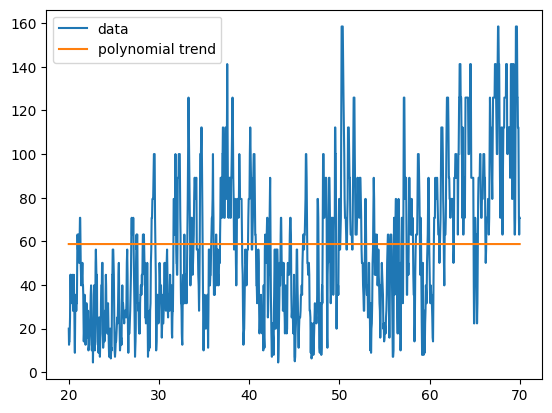

[58.75691591]


In [22]:
x4=GPSF_segment1_4[['elevsmth']].values
y4=GPSF_segment1_4[['snr']].values
y4=10**(y4/20)
x0=np.median(x4)

pf4 = PolynomialFeatures(degree=0)
Xp4 = pf4.fit_transform(x4)
md4 = LinearRegression()

md4.fit(Xp4, y4)
trendp4 = md4.predict(Xp4)

mpl.plot(x4, y4)
mpl.plot(x4, trendp4)
mpl.legend(['data', 'polynomial trend'])
mpl.show()
print (md4.intercept_)

**2nd order polynomial**

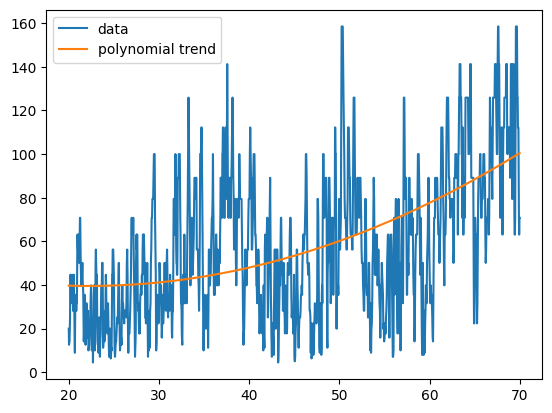

[52.31956898]


In [23]:
pf4 = PolynomialFeatures(degree=2)
Xp4 = pf4.fit_transform(x4-x0)
md4 = LinearRegression()

md4.fit(Xp4, y4)
trendp4 = md4.predict(Xp4)

mpl.plot(x4, y4)
mpl.plot(x4, trendp4)
mpl.legend(['data', 'polynomial trend'])
mpl.show()
print (md4.intercept_)

**PRN 9**

In [24]:
DF_GPSF9 = DF_GPSel.xs(9,level='PRN')
#print(DF_GPSF9)
DF_GPSazmax = DF_GPSF9['azsmth'].max()
DF_GPSazmin = DF_GPSF9['azsmth'].min()
print(DF_GPSazmin,',', DF_GPSazmax)

DF_GPSelmax = DF_GPSF9['elevsmth'].max()
DF_GPSelmin = DF_GPSF9['elevsmth'].min()
print(DF_GPSelmin,',', DF_GPSelmax)


DF_GPSFValue= DF_GPSF9.index.get_level_values('segment')
#print(DF_GPS9Value)
segment = []
for element in DF_GPSFValue:
    if element not in segment:
        segment.append(element)
print(segment)

71.0657894736842 , 93.99159663865547
20.02777777777778 , 69.95744680851064
[1]


**PRN 9 Segment 1**

In [25]:
GPSF_segment1_9=DF_GPSF9.xs(1,level='segment').reset_index()
print(GPSF_segment1_9['time'])

0      2022-03-26 01:52:27
1      2022-03-26 01:52:32
2      2022-03-26 01:52:37
3      2022-03-26 01:52:42
4      2022-03-26 01:52:47
               ...        
1421   2022-03-26 03:50:58
1422   2022-03-26 03:51:03
1423   2022-03-26 03:51:08
1424   2022-03-26 03:51:13
1425   2022-03-26 03:51:18
Name: time, Length: 1426, dtype: datetime64[ns]


**Mean/0 order polynomial**

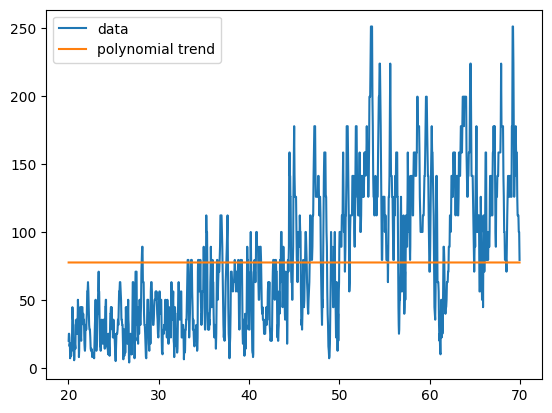

[77.55246947]


In [26]:
x9=GPSF_segment1_9[['elevsmth']].values
y9=GPSF_segment1_9[['snr']].values
y9=10**(y9/20)
x0=np.median(x9)

pf9 = PolynomialFeatures(degree=0)
Xp9 = pf9.fit_transform(x9)
md9 = LinearRegression()

md9.fit(Xp9, y9)
trendp9 = md9.predict(Xp9)

mpl.plot(x9, y9)
mpl.plot(x9, trendp9)
mpl.legend(['data', 'polynomial trend'])
mpl.show()
print (md9.intercept_)

**2nd order polynomial**

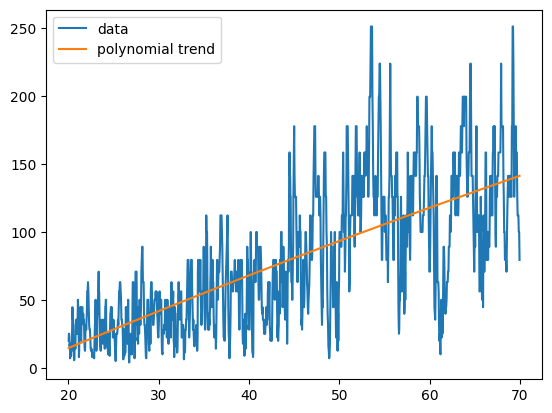

[77.46700832]


In [27]:
pf9 = PolynomialFeatures(degree=2)
Xp9 = pf9.fit_transform(x9-x0)
md9 = LinearRegression()

md9.fit(Xp9, y9)
trendp9 = md9.predict(Xp9)

mpl.plot(x9, y9)
mpl.plot(x9, trendp9)
mpl.legend(['data', 'polynomial trend'])
mpl.show()
print (md9.intercept_)

**PRN 7**

In [28]:
DF_GPSF7 = DF_GPSel.xs(7,level='PRN')
#print(DF_GPSF7)
DF_GPSazmax = DF_GPSF7['azsmth'].max()
DF_GPSazmin = DF_GPSF7['azsmth'].min()
print(DF_GPSazmin,',', DF_GPSazmax)

DF_GPSelmax = DF_GPSF7['elevsmth'].max()
DF_GPSelmin = DF_GPSF7['elevsmth'].min()
print(DF_GPSelmin,',', DF_GPSelmax)


DF_GPSFValue= DF_GPSF7.index.get_level_values('segment')
#print(DF_GPS7Value)
segment = []
for element in DF_GPSFValue:
    if element not in segment:
        segment.append(element)
print(segment)

63.0 , 119.93617021276596
20.02857142857143 , 69.9953488372093
[0, 1]


**PRN 7 Segment 0**

In [29]:
GPSF_segment0_7=DF_GPSF7.xs(0,level='segment').reset_index()
print(GPSF_segment0_7['time'])

0    2022-03-26 02:59:47
1    2022-03-26 02:59:52
2    2022-03-26 02:59:57
3    2022-03-26 03:00:02
4    2022-03-26 03:00:07
             ...        
67   2022-03-26 03:05:22
68   2022-03-26 03:05:27
69   2022-03-26 03:05:32
70   2022-03-26 03:05:37
71   2022-03-26 03:05:42
Name: time, Length: 72, dtype: datetime64[ns]


**Mean**

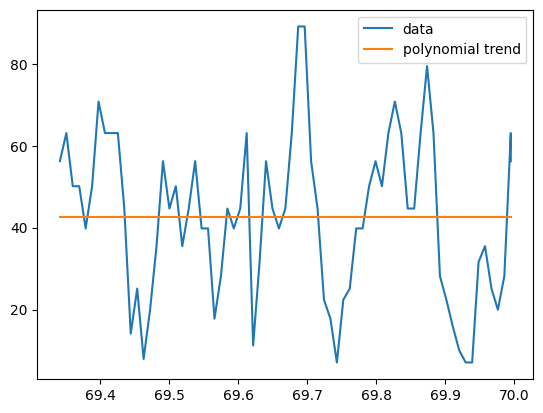

[42.57835269]


In [30]:
x7=GPSF_segment0_7[['elevsmth']].values
y7=GPSF_segment0_7[['snr']].values
y7=10**(y7/20)
x0=np.median(x7)

pf7 = PolynomialFeatures(degree=0)
Xp7 = pf7.fit_transform(x7)
md7 = LinearRegression()

md7.fit(Xp7, y7)
trendp7 = md7.predict(Xp7)

mpl.plot(x7, y7)
mpl.plot(x7, trendp7)
mpl.legend(['data', 'polynomial trend'])
mpl.show()
print (md7.intercept_)

**Polynomial**

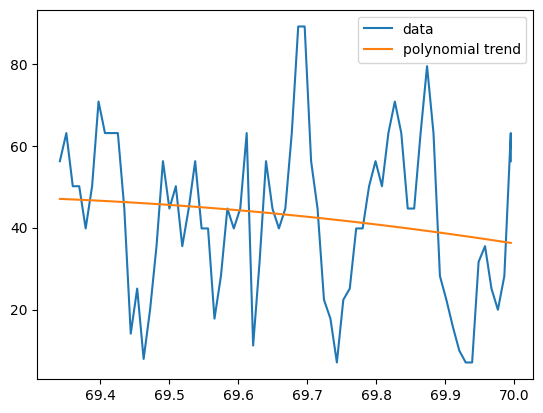

[43.1206705]


In [31]:
pf7 = PolynomialFeatures(degree=2)
Xp7 = pf7.fit_transform(x7-x0)
md7 = LinearRegression()

md7.fit(Xp7, y7)
trendp7 = md7.predict(Xp7)

mpl.plot(x7, y7)
mpl.plot(x7, trendp7)
mpl.legend(['data', 'polynomial trend'])
mpl.show()
print (md7.intercept_)

**PRN 7 Segment 1**

In [32]:
GPSF_segment1_7=DF_GPSF7.xs(1,level='segment').reset_index()
print(GPSF_segment1_7['time'])

0      2022-03-26 03:05:47
1      2022-03-26 03:05:52
2      2022-03-26 03:05:57
3      2022-03-26 03:06:02
4      2022-03-26 03:06:07
               ...        
1692   2022-03-26 05:27:08
1693   2022-03-26 05:27:13
1694   2022-03-26 05:27:18
1695   2022-03-26 05:27:23
1696   2022-03-26 05:27:28
Name: time, Length: 1697, dtype: datetime64[ns]


**Mean**

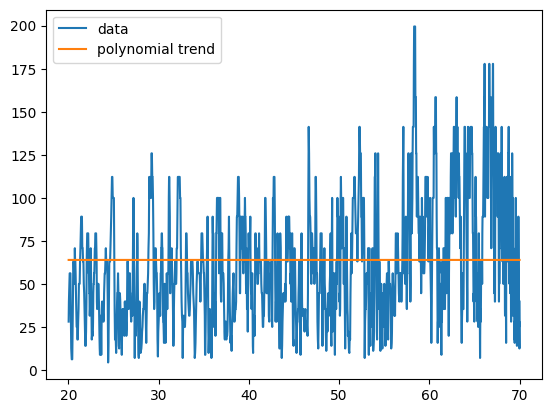

[63.99867561]


In [33]:
x7=GPSF_segment1_7[['elevsmth']].values
y7=GPSF_segment1_7[['snr']].values
y7=10**(y7/20)
x0=np.median(x7)

pf7 = PolynomialFeatures(degree=0)
Xp7 = pf7.fit_transform(x7)
md7 = LinearRegression()

md7.fit(Xp7, y7)
trendp7 = md7.predict(Xp7)

mpl.plot(x7, y7)
mpl.plot(x7, trendp7)
mpl.legend(['data', 'polynomial trend'])
mpl.show()
print (md7.intercept_)

**Polynomial**

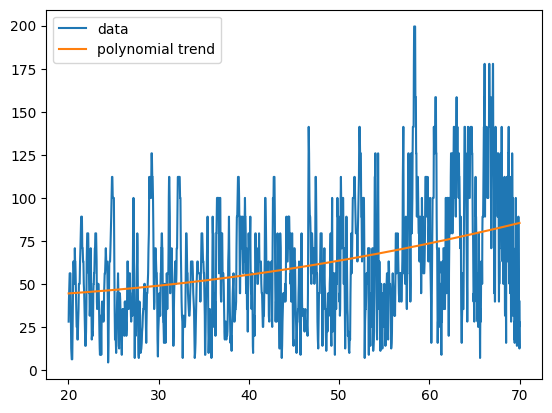

[62.82595002]


In [34]:
pf7 = PolynomialFeatures(degree=2)
Xp7 = pf7.fit_transform(x7-x0)
md7 = LinearRegression()

md7.fit(Xp7, y7)
trendp7 = md7.predict(Xp7)

mpl.plot(x7, y7)
mpl.plot(x7, trendp7)
mpl.legend(['data', 'polynomial trend'])
mpl.show()
print (md7.intercept_)

**PRN 30**

In [35]:
DF_GPSF30 = DF_GPSel.xs(30,level='PRN')
#print(DF_GPSF30)
DF_GPSazmax = DF_GPSF30['azsmth'].max()
DF_GPSazmin = DF_GPSF30['azsmth'].min()
print(DF_GPSazmin,',', DF_GPSazmax)

DF_GPSelmax = DF_GPSF30['elevsmth'].max()
DF_GPSelmin = DF_GPSF30['elevsmth'].min()
print(DF_GPSelmin,',', DF_GPSelmax)


DF_GPSFValue= DF_GPSF30.index.get_level_values('segment')
#print(DF_GPS30Value)
segment = []
for element in DF_GPSFValue:
    if element not in segment:
        segment.append(element)
print(segment)

69.0 , 81.93617021276596
20.04255319148936 , 69.98591549295774
[3]


**PRN 30 segment 3**

In [36]:
GPSF_segment3_30=DF_GPSF30.xs(3,level='segment').reset_index()
print(GPSF_segment3_30['time'])

0      2022-03-26 04:26:27
1      2022-03-26 04:26:32
2      2022-03-26 04:26:37
3      2022-03-26 04:26:42
4      2022-03-26 04:26:47
               ...        
1433   2022-03-26 06:25:58
1434   2022-03-26 06:26:03
1435   2022-03-26 06:26:08
1436   2022-03-26 06:26:13
1437   2022-03-26 06:26:18
Name: time, Length: 1438, dtype: datetime64[ns]


**Mean**

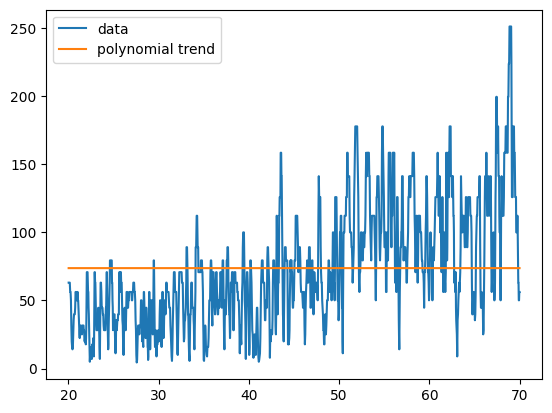

[73.74895138]


In [37]:
x30=GPSF_segment3_30[['elevsmth']].values
y30=GPSF_segment3_30[['snr']].values
y30=10**(y30/20)
x0=np.median(x30)

pf30 = PolynomialFeatures(degree=0)
Xp30 = pf30.fit_transform(x30)
md30 = LinearRegression()

md30.fit(Xp30, y30)
trendp30 = md30.predict(Xp30)

mpl.plot(x30, y30)
mpl.plot(x30, trendp30)
mpl.legend(['data', 'polynomial trend'])
mpl.show()
print (md30.intercept_)

**Polynomial**

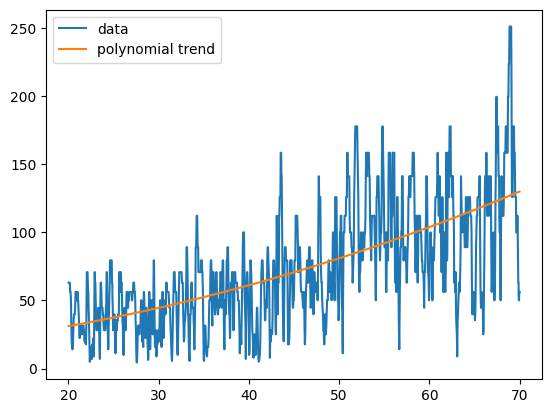

[69.71642529]


In [38]:
pf30 = PolynomialFeatures(degree=2)
Xp30 = pf30.fit_transform(x30-x0)
md30 = LinearRegression()

md30.fit(Xp30, y30)
trendp30 = md30.predict(Xp30)

mpl.plot(x30, y30)
mpl.plot(x30, trendp30)
mpl.legend(['data', 'polynomial trend'])
mpl.show()
print (md30.intercept_)

**PRN 14**

In [39]:
DF_GPSF14 = DF_GPSel.xs(14,level='PRN')
#print(DF_GPSF14)
DF_GPSazmax = DF_GPSF14['azsmth'].max()
DF_GPSazmin = DF_GPSF14['azsmth'].min()
print(DF_GPSazmin,',', DF_GPSazmax)

DF_GPSelmax = DF_GPSF14['elevsmth'].max()
DF_GPSelmin = DF_GPSF14['elevsmth'].min()
print(DF_GPSelmin,',', DF_GPSelmax)


DF_GPSFValue= DF_GPSF14.index.get_level_values('segment')
#print(DF_GPS14Value)
segment = []
for element in DF_GPSFValue:
    if element not in segment:
        segment.append(element)
print(segment)

54.0 , 119.91666666666667
20.028169014084508 , 55.997668997668995
[2, 3]


**PRN 14 Segment 2**

In [40]:
GPSF_segment2_14=DF_GPSF14.xs(2,level='segment').reset_index()
print(GPSF_segment2_14['time'])

0     2022-03-26 05:27:42
1     2022-03-26 05:27:47
2     2022-03-26 05:27:52
3     2022-03-26 05:27:57
4     2022-03-26 05:28:02
              ...        
340   2022-03-26 05:56:02
341   2022-03-26 05:56:07
342   2022-03-26 05:56:12
343   2022-03-26 05:56:17
344   2022-03-26 05:56:22
Name: time, Length: 345, dtype: datetime64[ns]


**Mean**

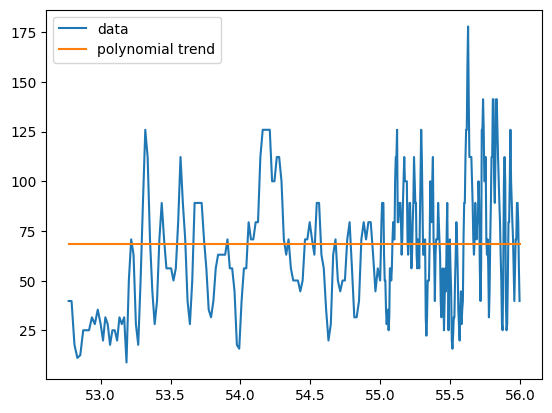

[68.59533381]


In [41]:
x14=GPSF_segment2_14[['elevsmth']].values
y14=GPSF_segment2_14[['snr']].values
y14=10**(y14/20)
x0=np.median(x14)

pf14 = PolynomialFeatures(degree=0)
Xp14 = pf14.fit_transform(x14)
md14 = LinearRegression()

md14.fit(Xp14, y14)
trendp14 = md14.predict(Xp14)

mpl.plot(x14, y14)
mpl.plot(x14, trendp14)
mpl.legend(['data', 'polynomial trend'])
mpl.show()
print (md14.intercept_)

**Polynomial**

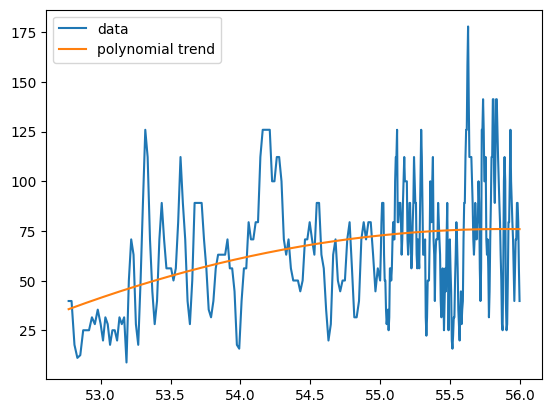

[74.04287207]


In [42]:
pf14 = PolynomialFeatures(degree=2)
Xp14 = pf14.fit_transform(x14-x0)
md14 = LinearRegression()

md14.fit(Xp14, y14)
trendp14 = md14.predict(Xp14)

mpl.plot(x14, y14)
mpl.plot(x14, trendp14)
mpl.legend(['data', 'polynomial trend'])
mpl.show()
print (md14.intercept_)

**PRN 14 Segment 3**

In [43]:
GPSF_segment3_14=DF_GPSF14.xs(3,level='segment').reset_index()
print(GPSF_segment3_14['time'])

0      2022-03-26 05:56:27
1      2022-03-26 05:56:32
2      2022-03-26 05:56:37
3      2022-03-26 05:56:42
4      2022-03-26 05:56:47
               ...        
1422   2022-03-26 07:54:58
1423   2022-03-26 07:55:03
1424   2022-03-26 07:55:08
1425   2022-03-26 07:55:13
1426   2022-03-26 07:55:18
Name: time, Length: 1427, dtype: datetime64[ns]


**Mean**

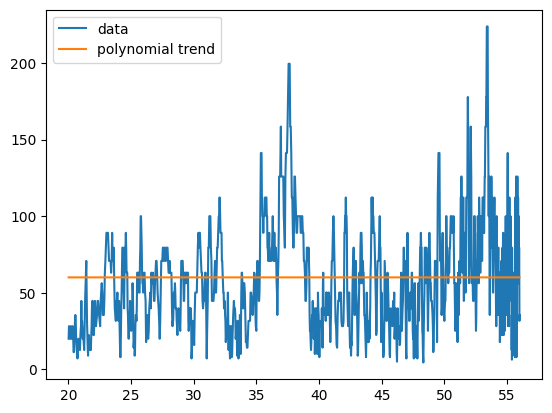

[60.0421744]


In [44]:
x14=GPSF_segment3_14[['elevsmth']].values
y14=GPSF_segment3_14[['snr']].values
y14=10**(y14/20)
x0=np.median(x14)

pf14 = PolynomialFeatures(degree=0)
Xp14 = pf14.fit_transform(x14)
md14 = LinearRegression()

md14.fit(Xp14, y14)
trendp14 = md14.predict(Xp14)

mpl.plot(x14, y14)
mpl.plot(x14, trendp14)
mpl.legend(['data', 'polynomial trend'])
mpl.show()
print (md14.intercept_)

**Polynomial**

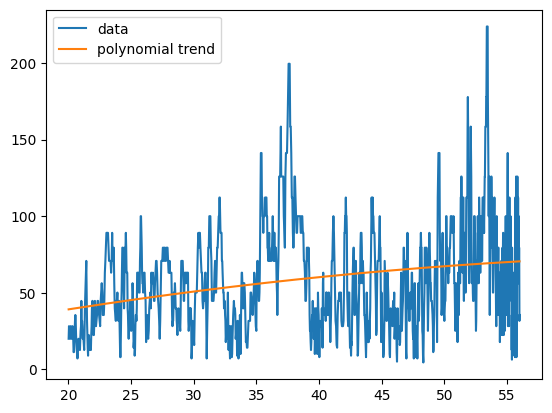

[62.80187214]


In [45]:
pf14 = PolynomialFeatures(degree=2)
Xp14 = pf14.fit_transform(x14-x0)
md14 = LinearRegression()

md14.fit(Xp14, y14)
trendp14 = md14.predict(Xp14)

mpl.plot(x14, y14)
mpl.plot(x14, trendp14)
mpl.legend(['data', 'polynomial trend'])
mpl.show()
print (md14.intercept_)

**PRN 17**

In [46]:
DF_GPSF17 = DF_GPSel.xs(17,level='PRN')
#print(DF_GPSF17)
DF_GPSazmax = DF_GPSF17['azsmth'].max()
DF_GPSazmin = DF_GPSF17['azsmth'].min()
print(DF_GPSazmin,',', DF_GPSazmax)

DF_GPSelmax = DF_GPSF17['elevsmth'].max()
DF_GPSelmin = DF_GPSF17['elevsmth'].min()
print(DF_GPSelmin,',', DF_GPSelmax)


DF_GPSFValue= DF_GPSF17.index.get_level_values('segment')
#print(DF_GPS17Value)
segment = []
for element in DF_GPSFValue:
    if element not in segment:
        segment.append(element)
print(segment)

40.21848739495798 , 109.97183098591549
20.028169014084508 , 35.998
[6, 7]


**PRN 17 Segment 6**

In [47]:
GPSF_segment6_17=DF_GPSF17.xs(6,level='segment').reset_index()
print(GPSF_segment6_17['time'])

0     2022-03-26 06:45:08
1     2022-03-26 06:45:13
2     2022-03-26 06:45:18
3     2022-03-26 06:45:23
4     2022-03-26 06:45:28
              ...        
981   2022-03-26 08:06:57
982   2022-03-26 08:07:02
983   2022-03-26 08:07:07
984   2022-03-26 08:07:12
985   2022-03-26 08:07:17
Name: time, Length: 986, dtype: datetime64[ns]


**Mean**

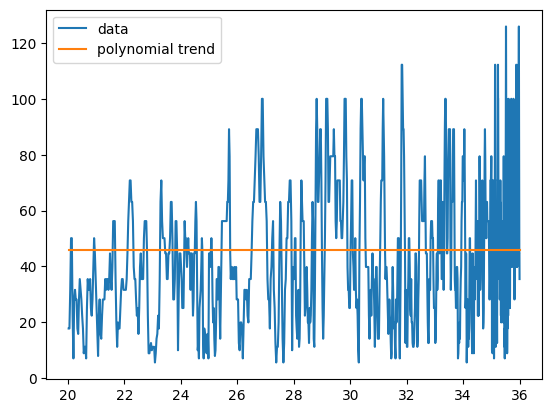

[45.793977]


In [48]:
x17=GPSF_segment6_17[['elevsmth']].values
y17=GPSF_segment6_17[['snr']].values
y17=10**(y17/20)
x0=np.median(x17)

pf17 = PolynomialFeatures(degree=0)
Xp17 = pf17.fit_transform(x17)
md17 = LinearRegression()

md17.fit(Xp17, y17)
trendp17 = md17.predict(Xp17)

mpl.plot(x17, y17)
mpl.plot(x17, trendp17)
mpl.legend(['data', 'polynomial trend'])
mpl.show()
print (md17.intercept_)

**Polynomial**

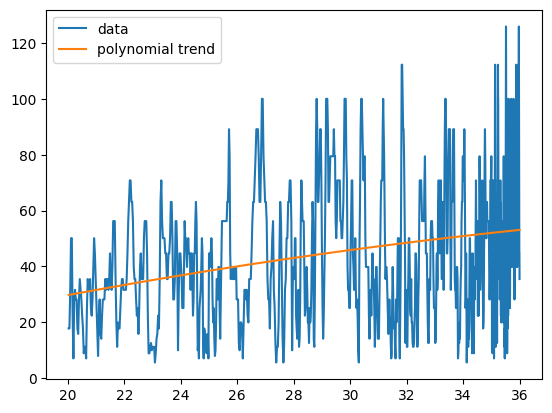

[48.09407233]


In [49]:
pf17 = PolynomialFeatures(degree=2)
Xp17 = pf17.fit_transform(x17-x0)
md17 = LinearRegression()

md17.fit(Xp17, y17)
trendp17 = md17.predict(Xp17)

mpl.plot(x17, y17)
mpl.plot(x17, trendp17)
mpl.legend(['data', 'polynomial trend'])
mpl.show()
print (md17.intercept_)

**PRN 17 Segment 7**

In [50]:
GPSF_segment7_17=DF_GPSF17.xs(7,level='segment').reset_index()
print(GPSF_segment7_17['time'])

0     2022-03-26 08:07:22
1     2022-03-26 08:07:27
2     2022-03-26 08:07:32
3     2022-03-26 08:07:37
4     2022-03-26 08:07:42
              ...        
970   2022-03-26 09:28:13
971   2022-03-26 09:28:18
972   2022-03-26 09:28:23
973   2022-03-26 09:28:28
974   2022-03-26 09:28:33
Name: time, Length: 975, dtype: datetime64[ns]


**Mean**

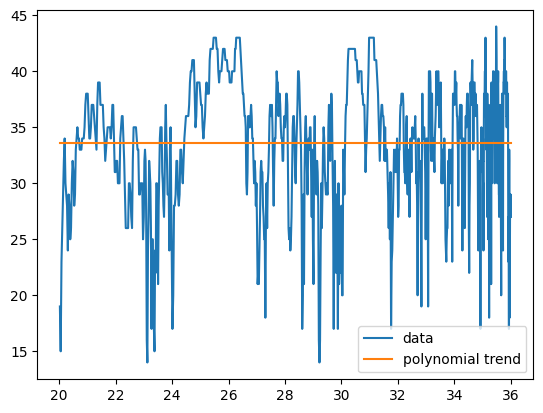

[33.55179487]


In [51]:
x17=GPSF_segment7_17[['elevsmth']].values
y17=GPSF_segment7_17[['snr']].values
#y17=10**(y17/20)
x0=np.median(x17)

pf17 = PolynomialFeatures(degree=0)
Xp17 = pf17.fit_transform(x17)
md17 = LinearRegression()

md17.fit(Xp17, y17)
trendp17 = md17.predict(Xp17)

mpl.plot(x17, y17)
mpl.plot(x17, trendp17)
mpl.legend(['data', 'polynomial trend'])
mpl.show()
print (md17.intercept_)

**Polynomial**

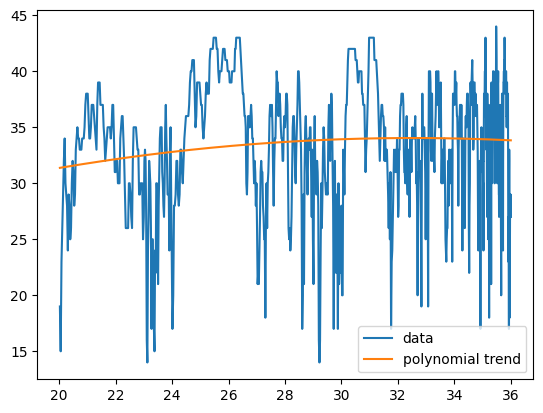

[34.02361946]


In [52]:
pf17 = PolynomialFeatures(degree=2)
Xp17 = pf17.fit_transform(x17-x0)
md17 = LinearRegression()

md17.fit(Xp17, y17)
trendp17 = md17.predict(Xp17)

mpl.plot(x17, y17)
mpl.plot(x17, trendp17)
mpl.legend(['data', 'polynomial trend'])
mpl.show()
print (md17.intercept_)

**PRN 19**

In [53]:
DF_GPSF19 = DF_GPSel.xs(19,level='PRN')
#print(DF_GPSF19)
DF_GPSazmax = DF_GPSF19['azsmth'].max()
DF_GPSazmin = DF_GPSF19['azsmth'].min()
print(DF_GPSazmin,',', DF_GPSazmax)

DF_GPSelmax = DF_GPSF19['elevsmth'].max()
DF_GPSelmin = DF_GPSF19['elevsmth'].min()
print(DF_GPSelmin,',', DF_GPSelmax)


DF_GPSFValue= DF_GPSF19.index.get_level_values('segment')
#print(DF_GPS19Value)
segment = []
for element in DF_GPSFValue:
    if element not in segment:
        segment.append(element)
print(segment)

42.34507042253521 , 119.98591549295774
20.02777777777778 , 42.0
[2, 3]


**PRN 19 Segment 2**

In [54]:
GPSF_segment2_19=DF_GPSF19.xs(2,level='segment').reset_index()
print(GPSF_segment2_19['time'])

0     2022-03-26 07:23:43
1     2022-03-26 07:23:48
2     2022-03-26 07:23:53
3     2022-03-26 07:23:58
4     2022-03-26 07:24:03
              ...        
992   2022-03-26 08:46:42
993   2022-03-26 08:46:47
994   2022-03-26 08:46:52
995   2022-03-26 08:46:57
996   2022-03-26 08:47:02
Name: time, Length: 997, dtype: datetime64[ns]


**Mean**

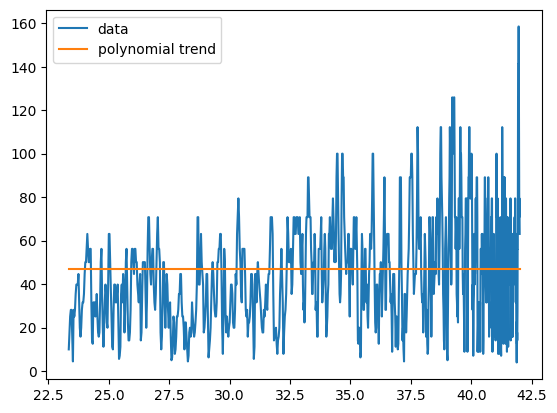

[46.94064971]


In [55]:
x19=GPSF_segment2_19[['elevsmth']].values
y19=GPSF_segment2_19[['snr']].values
y19=10**(y19/20)
x0=np.median(x19)

pf19 = PolynomialFeatures(degree=0)
Xp19 = pf19.fit_transform(x19)
md19 = LinearRegression()

md19.fit(Xp19, y19)
trendp19 = md19.predict(Xp19)

mpl.plot(x19, y19)
mpl.plot(x19, trendp19)
mpl.legend(['data', 'polynomial trend'])
mpl.show()
print (md19.intercept_)

**Polynomial**

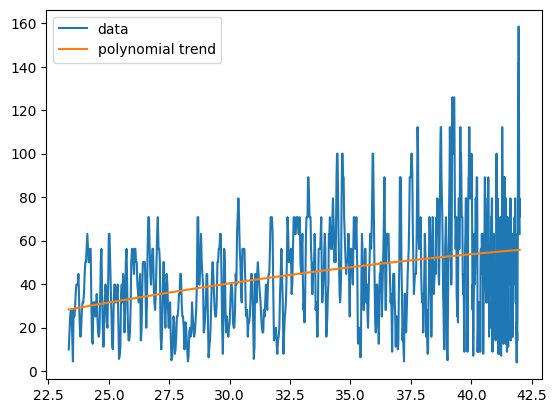

[49.4278585]


In [56]:
pf19 = PolynomialFeatures(degree=2)
Xp19 = pf19.fit_transform(x19-x0)
md19 = LinearRegression()

md19.fit(Xp19, y19)
trendp19 = md19.predict(Xp19)

mpl.plot(x19, y19)
mpl.plot(x19, trendp19)
mpl.legend(['data', 'polynomial trend'])
mpl.show()
print (md19.intercept_)

**PRN 19 Segment 3**

In [57]:
GPSF_segment3_19=DF_GPSF19.xs(3,level='segment').reset_index()
print(GPSF_segment3_19['time'])

0      2022-03-26 08:47:07
1      2022-03-26 08:47:12
2      2022-03-26 08:47:17
3      2022-03-26 08:47:22
4      2022-03-26 08:47:27
               ...        
1065   2022-03-26 10:15:53
1066   2022-03-26 10:15:58
1067   2022-03-26 10:16:03
1068   2022-03-26 10:16:08
1069   2022-03-26 10:16:13
Name: time, Length: 1070, dtype: datetime64[ns]


**Mean**

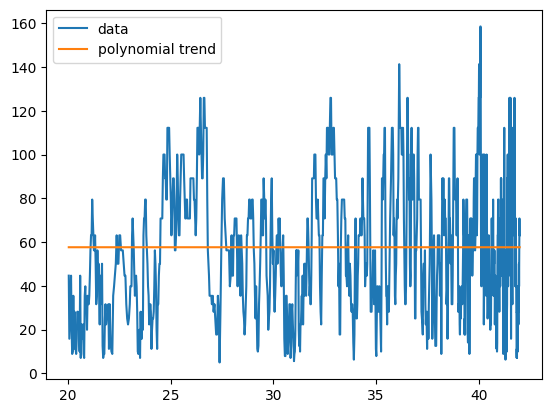

[57.65038897]


In [58]:
x19=GPSF_segment3_19[['elevsmth']].values
y19=GPSF_segment3_19[['snr']].values
y19=10**(y19/20)
x0=np.median(x19)

pf19 = PolynomialFeatures(degree=0)
Xp19 = pf19.fit_transform(x19)
md19 = LinearRegression()

md19.fit(Xp19, y19)
trendp19 = md19.predict(Xp19)

mpl.plot(x19, y19)
mpl.plot(x19, trendp19)
mpl.legend(['data', 'polynomial trend'])
mpl.show()
print (md19.intercept_)

**Polynomial**

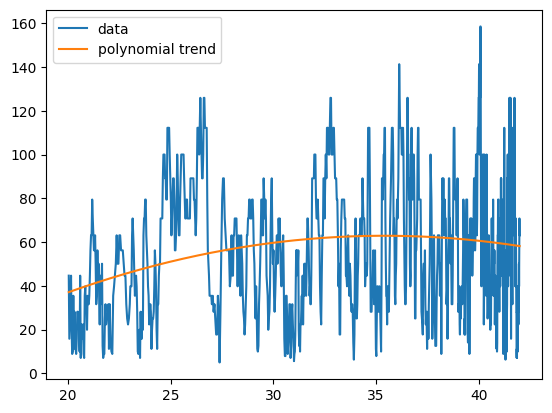

[62.88046201]


In [59]:
pf19 = PolynomialFeatures(degree=2)
Xp19 = pf19.fit_transform(x19-x0)
md19 = LinearRegression()

md19.fit(Xp19, y19)
trendp19 = md19.predict(Xp19)

mpl.plot(x19, y19)
mpl.plot(x19, trendp19)
mpl.legend(['data', 'polynomial trend'])
mpl.show()
print (md19.intercept_)

**PRN 6**

In [60]:
DF_GPSF6 = DF_GPSel.xs(6,level='PRN')
#print(DF_GPSF6)
DF_GPSazmax = DF_GPSF6['azsmth'].max()
DF_GPSazmin = DF_GPSF6['azsmth'].min()
print(DF_GPSazmin,',', DF_GPSazmax)

DF_GPSelmax = DF_GPSF6['elevsmth'].max()
DF_GPSelmin = DF_GPSF6['elevsmth'].min()
print(DF_GPSelmin,',', DF_GPSelmax)


DF_GPSFValue= DF_GPSF6.index.get_level_values('segment')
#print(DF_GPS19Value)
segment = []
for element in DF_GPSFValue:
    if element not in segment:
        segment.append(element)
print(segment)

39.352112676056336 , 75.98571428571428
20.008403361344538 , 24.0
[4, 5]


**PRN 6 Segment 4**

In [61]:
GPSF_segment4_6=DF_GPSF6.xs(4,level='segment').reset_index()
print(GPSF_segment4_6['time'])

0     2022-03-26 10:01:13
1     2022-03-26 10:01:18
2     2022-03-26 10:01:23
3     2022-03-26 10:01:28
4     2022-03-26 10:01:38
              ...        
494   2022-03-26 10:42:33
495   2022-03-26 10:42:38
496   2022-03-26 10:42:43
497   2022-03-26 10:42:48
498   2022-03-26 10:42:53
Name: time, Length: 499, dtype: datetime64[ns]


**Mean**

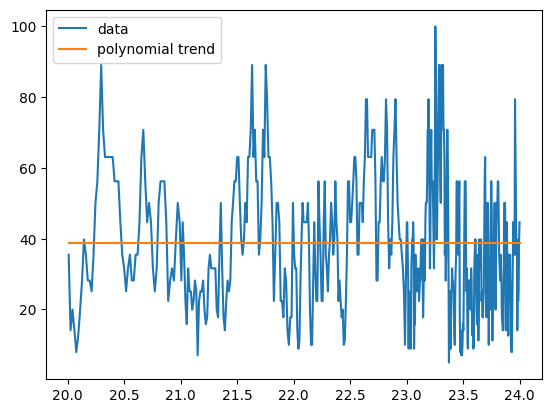

[38.76335258]


In [62]:
x6=GPSF_segment4_6[['elevsmth']].values
y6=GPSF_segment4_6[['snr']].values
y6=10**(y6/20)
x0=np.median(x6)

pf6 = PolynomialFeatures(degree=0)
Xp6 = pf6.fit_transform(x6)
md6 = LinearRegression()

md6.fit(Xp6, y6)
trendp6 = md6.predict(Xp6)

mpl.plot(x6, y6)
mpl.plot(x6, trendp6)
mpl.legend(['data', 'polynomial trend'])
mpl.show()
print (md6.intercept_)

**Polynomial**

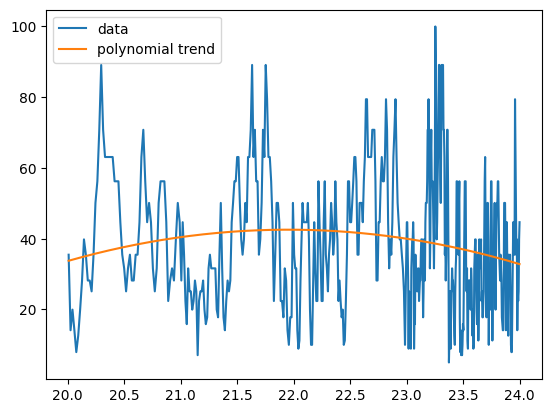

[39.99801095]


In [63]:
pf6 = PolynomialFeatures(degree=2)
Xp6 = pf6.fit_transform(x6-x0)
md6 = LinearRegression()

md6.fit(Xp6, y6)
trendp6 = md6.predict(Xp6)

mpl.plot(x6, y6)
mpl.plot(x6, trendp6)
mpl.legend(['data', 'polynomial trend'])
mpl.show()
print (md6.intercept_)

**PRN 6 Segment 5**

In [64]:
GPSF_segment5_6=DF_GPSF6.xs(5,level='segment').reset_index()
print(GPSF_segment5_6['time'])

0     2022-03-26 10:42:58
1     2022-03-26 10:43:03
2     2022-03-26 10:43:08
3     2022-03-26 10:43:13
4     2022-03-26 10:43:18
              ...        
480   2022-03-26 11:23:08
481   2022-03-26 11:23:13
482   2022-03-26 11:23:18
483   2022-03-26 11:23:23
484   2022-03-26 11:23:28
Name: time, Length: 485, dtype: datetime64[ns]


**Mean**

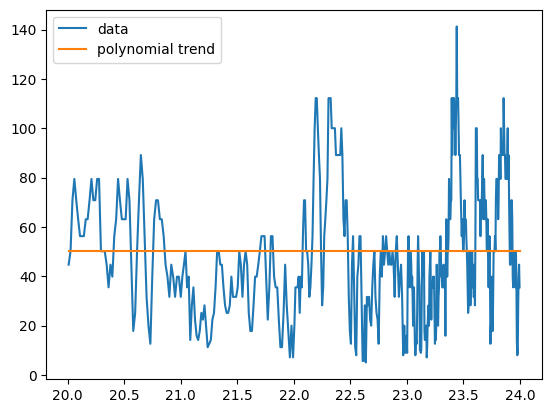

[50.02994826]


In [65]:
x6=GPSF_segment5_6[['elevsmth']].values
y6=GPSF_segment5_6[['snr']].values
y6=10**(y6/20)
x0=np.median(x6)

pf6 = PolynomialFeatures(degree=0)
Xp6 = pf6.fit_transform(x6)
md6 = LinearRegression()

md6.fit(Xp6, y6)
trendp6 = md6.predict(Xp6)

mpl.plot(x6, y6)
mpl.plot(x6, trendp6)
mpl.legend(['data', 'polynomial trend'])
mpl.show()
print (md6.intercept_)

**Polynomial**

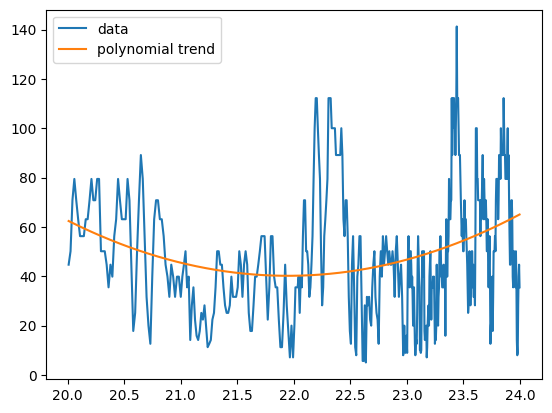

[47.00421649]


In [66]:
pf6 = PolynomialFeatures(degree=2)
Xp6 = pf6.fit_transform(x6-x0)
md6 = LinearRegression()

md6.fit(Xp6, y6)
trendp6 = md6.predict(Xp6)

mpl.plot(x6, y6)
mpl.plot(x6, trendp6)
mpl.legend(['data', 'polynomial trend'])
mpl.show()
print (md6.intercept_)

**PRN 2**

In [67]:
DF_GPSF2 = DF_GPSel.xs(2,level='PRN')
#print(DF_GPSF2)
DF_GPSazmax = DF_GPSF2['azsmth'].max()
DF_GPSazmin = DF_GPSF2['azsmth'].min()
print(DF_GPSazmin,',', DF_GPSazmax)

DF_GPSelmax = DF_GPSF2['elevsmth'].max()
DF_GPSelmin = DF_GPSF2['elevsmth'].min()
print(DF_GPSelmin,',', DF_GPSelmax)


DF_GPSFValue= DF_GPSF2.index.get_level_values('segment')
#print(DF_GPS2Value)
segment = []
for element in DF_GPSFValue:
    if element not in segment:
        segment.append(element)
print(segment)

42.00704225352113 , 114.72916666666667
20.02777777777778 , 37.99752475247525
[4, 5]


**PRN 2 Segment 4**

In [68]:
GPSF_segment4_2=DF_GPSF2.xs(4,level='segment').reset_index()
print(GPSF_segment4_2['time'])

0      2022-03-26 10:20:03
1      2022-03-26 10:20:08
2      2022-03-26 10:20:13
3      2022-03-26 10:20:18
4      2022-03-26 10:20:23
               ...        
1030   2022-03-26 11:45:53
1031   2022-03-26 11:45:58
1032   2022-03-26 11:46:03
1033   2022-03-26 11:46:08
1034   2022-03-26 11:46:13
Name: time, Length: 1035, dtype: datetime64[ns]


**Mean**

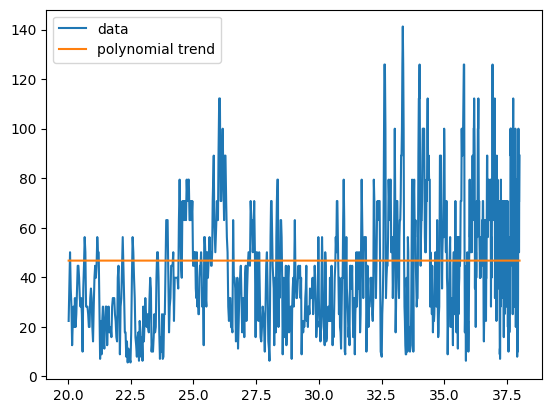

[46.74407257]


In [69]:
x2=GPSF_segment4_2[['elevsmth']].values
y2=GPSF_segment4_2[['snr']].values
y2=10**(y2/20)
x0=np.median(x2)

pf2 = PolynomialFeatures(degree=0)
Xp2 = pf2.fit_transform(x2)
md2 = LinearRegression()

md2.fit(Xp2, y2)
trendp2 = md2.predict(Xp2)

mpl.plot(x2, y2)
mpl.plot(x2, trendp2)
mpl.legend(['data', 'polynomial trend'])
mpl.show()
print (md2.intercept_)

**Polynomial**

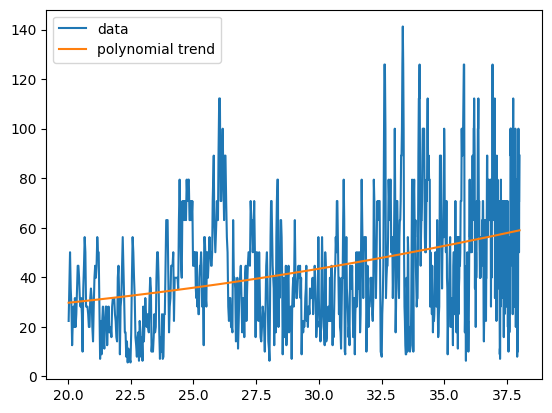

[48.11268875]


In [70]:
pf2 = PolynomialFeatures(degree=2)
Xp2 = pf2.fit_transform(x2-x0)
md2 = LinearRegression()

md2.fit(Xp2, y2)
trendp2 = md2.predict(Xp2)

mpl.plot(x2, y2)
mpl.plot(x2, trendp2)
mpl.legend(['data', 'polynomial trend'])
mpl.show()
print (md2.intercept_)

**PRN 2 Segment 5**

In [71]:
GPSF_segment5_2=DF_GPSF2.xs(5,level='segment').reset_index()
print(GPSF_segment5_2['time'])

0      2022-03-26 11:46:18
1      2022-03-26 11:46:23
2      2022-03-26 11:46:28
3      2022-03-26 11:46:33
4      2022-03-26 11:46:38
               ...        
1054   2022-03-26 13:14:08
1055   2022-03-26 13:14:13
1056   2022-03-26 13:14:18
1057   2022-03-26 13:14:23
1058   2022-03-26 13:14:28
Name: time, Length: 1059, dtype: datetime64[ns]


**Mean**

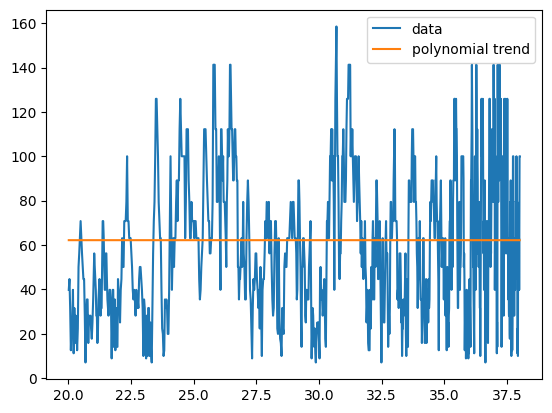

[62.19265532]


In [72]:
x2=GPSF_segment5_2[['elevsmth']].values
y2=GPSF_segment5_2[['snr']].values
y2=10**(y2/20)
x0=np.median(x2)

pf2 = PolynomialFeatures(degree=0)
Xp2 = pf2.fit_transform(x2)
md2 = LinearRegression()

md2.fit(Xp2, y2)
trendp2 = md2.predict(Xp2)

mpl.plot(x2, y2)
mpl.plot(x2, trendp2)
mpl.legend(['data', 'polynomial trend'])
mpl.show()
print (md2.intercept_)

**Polynomial**

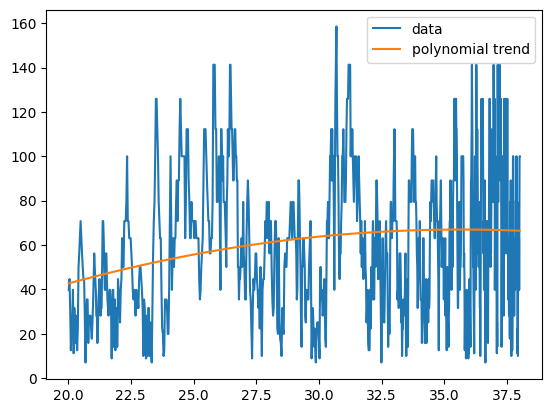

[66.12582244]


In [73]:
pf2 = PolynomialFeatures(degree=2)
Xp2 = pf2.fit_transform(x2-x0)
md2 = LinearRegression()

md2.fit(Xp2, y2)
trendp2 = md2.predict(Xp2)

mpl.plot(x2, y2)
mpl.plot(x2, trendp2)
mpl.legend(['data', 'polynomial trend'])
mpl.show()
print (md2.intercept_)

**PRN 12**

In [74]:
DF_GPSF12 = DF_GPSel.xs(12,level='PRN')
#print(DF_GPSF12)
DF_GPSazmax = DF_GPSF12['azsmth'].max()
DF_GPSazmin = DF_GPSF12['azsmth'].min()
print(DF_GPSazmin,',', DF_GPSazmax)

DF_GPSelmax = DF_GPSF12['elevsmth'].max()
DF_GPSelmin = DF_GPSF12['elevsmth'].min()
print(DF_GPSelmin,',', DF_GPSelmax)


DF_GPSFValue= DF_GPSF12.index.get_level_values('segment')
#print(DF_GPS12Value)
segment = []
for element in DF_GPSFValue:
    if element not in segment:
        segment.append(element)
print(segment)

68.77083333333333 , 100.22916666666667
20.028169014084508 , 69.95833333333333
[1]


**PRN 12 Segment 1**

In [75]:
GPSF_segment1_12=DF_GPSF12.xs(1,level='segment').reset_index()
print(GPSF_segment1_12['time'])

0      2022-03-26 10:42:02
1      2022-03-26 10:42:07
2      2022-03-26 10:42:12
3      2022-03-26 10:42:17
4      2022-03-26 10:42:22
               ...        
1420   2022-03-26 12:40:33
1421   2022-03-26 12:40:38
1422   2022-03-26 12:40:43
1423   2022-03-26 12:40:48
1424   2022-03-26 12:40:53
Name: time, Length: 1425, dtype: datetime64[ns]


**Mean**

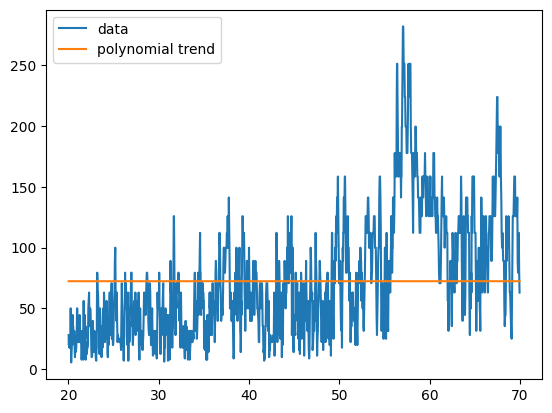

[72.43543059]


In [76]:
x12=GPSF_segment1_12[['elevsmth']].values
y12=GPSF_segment1_12[['snr']].values
y12=10**(y12/20)
x0=np.median(x12)

pf12 = PolynomialFeatures(degree=0)
Xp12 = pf12.fit_transform(x12)
md12 = LinearRegression()

md12.fit(Xp12, y12)
trendp12 = md12.predict(Xp12)

mpl.plot(x12, y12)
mpl.plot(x12, trendp12)
mpl.legend(['data', 'polynomial trend'])
mpl.show()
print (md12.intercept_)

**Polynomial**

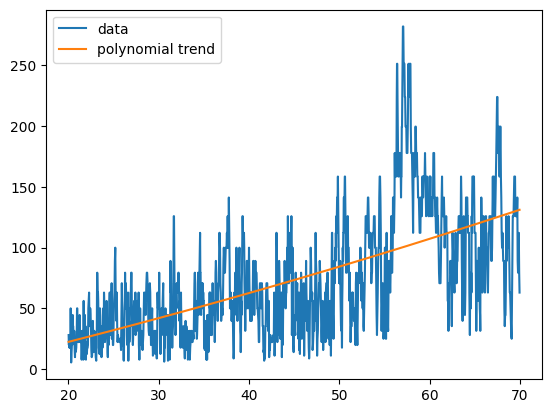

[70.460866]


In [77]:
pf12 = PolynomialFeatures(degree=2)
Xp12 = pf12.fit_transform(x12-x0)
md12 = LinearRegression()

md12.fit(Xp12, y12)
trendp12 = md12.predict(Xp12)

mpl.plot(x12, y12)
mpl.plot(x12, trendp12)
mpl.legend(['data', 'polynomial trend'])
mpl.show()
print (md12.intercept_)

**PRN 25**

In [78]:
DF_GPSF25 = DF_GPSel.xs(25,level='PRN')
#print(DF_GPSF25)
DF_GPSazmax = DF_GPSF25['azsmth'].max()
DF_GPSazmin = DF_GPSF25['azsmth'].min()
print(DF_GPSazmin,',', DF_GPSazmax)

DF_GPSelmax = DF_GPSF25['elevsmth'].max()
DF_GPSelmin = DF_GPSF25['elevsmth'].min()
print(DF_GPSelmin,',', DF_GPSelmax)


DF_GPSFValue= DF_GPSF25.index.get_level_values('segment')
#print(DF_GPS25Value)
segment = []
for element in DF_GPSFValue:
    if element not in segment:
        segment.append(element)
print(segment)

94.04166666666667 , 119.98947368421052
32.51063829787234 , 69.95833333333333
[5]


**PRN 25 Segment 5**

In [79]:
GPSF_segment5_25=DF_GPSF25.xs(5,level='segment').reset_index()
print(GPSF_segment5_25['time'])

0      2022-03-26 12:19:27
1      2022-03-26 12:19:32
2      2022-03-26 12:19:37
3      2022-03-26 12:19:42
4      2022-03-26 12:19:47
               ...        
1005   2022-03-26 13:43:18
1006   2022-03-26 13:43:23
1007   2022-03-26 13:43:28
1008   2022-03-26 13:43:33
1009   2022-03-26 13:43:38
Name: time, Length: 1010, dtype: datetime64[ns]


**Mean**

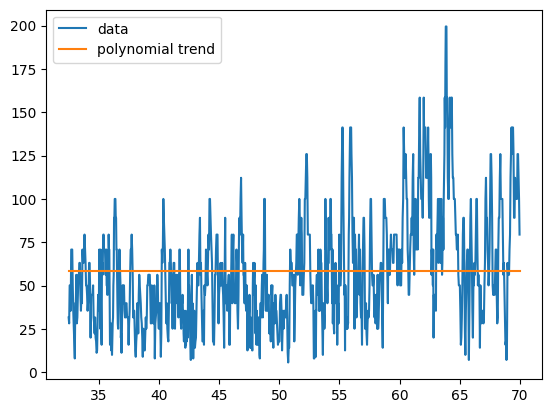

[58.57607926]


In [80]:
x25=GPSF_segment5_25[['elevsmth']].values
y25=GPSF_segment5_25[['snr']].values
y25=10**(y25/20)
x0=np.median(x25)

pf25 = PolynomialFeatures(degree=0)
Xp25 = pf25.fit_transform(x25)
md25 = LinearRegression()

md25.fit(Xp25, y25)
trendp25 = md25.predict(Xp25)

mpl.plot(x25, y25)
mpl.plot(x25, trendp25)
mpl.legend(['data', 'polynomial trend'])
mpl.show()
print (md25.intercept_)

**Polynomial**

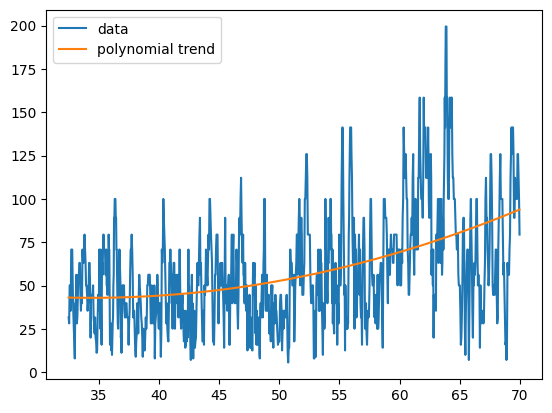

[53.69945744]


In [81]:
pf25 = PolynomialFeatures(degree=2)
Xp25 = pf25.fit_transform(x25-x0)
md25 = LinearRegression()

md25.fit(Xp25, y25)
trendp25 = md25.predict(Xp25)

mpl.plot(x25, y25)
mpl.plot(x25, trendp25)
mpl.legend(['data', 'polynomial trend'])
mpl.show()
print (md25.intercept_)

**PRN 29**

In [82]:
DF_GPSF29 = DF_GPSel.xs(29,level='PRN')
#print(DF_GPSF29)
DF_GPSazmax = DF_GPSF29['azsmth'].max()
DF_GPSazmin = DF_GPSF29['azsmth'].min()
print(DF_GPSazmin,',', DF_GPSazmax)

DF_GPSelmax = DF_GPSF29['elevsmth'].max()
DF_GPSelmin = DF_GPSF29['elevsmth'].min()
print(DF_GPSelmin,',', DF_GPSelmax)


DF_GPSFValue= DF_GPSF29.index.get_level_values('segment')
#print(DF_GPS29Value)
segment = []
for element in DF_GPSFValue:
    if element not in segment:
        segment.append(element)
print(segment)

65.00280898876404 , 84.19327731092437
20.014084507042252 , 69.95833333333333
[9]


**PRN 29 Segment 9**

In [83]:
GPSF_segment9_29=DF_GPSF29.xs(9,level='segment').reset_index()
print(GPSF_segment9_29['time'])

0      2022-03-26 13:32:52
1      2022-03-26 13:32:57
2      2022-03-26 13:33:02
3      2022-03-26 13:33:07
4      2022-03-26 13:33:12
               ...        
1385   2022-03-26 15:28:28
1386   2022-03-26 15:28:33
1387   2022-03-26 15:28:38
1388   2022-03-26 15:28:43
1389   2022-03-26 15:28:48
Name: time, Length: 1390, dtype: datetime64[ns]


**Mean**

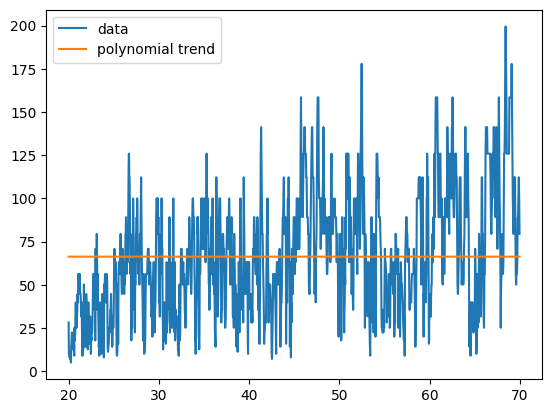

[66.27584492]


In [84]:
x29=GPSF_segment9_29[['elevsmth']].values
y29=GPSF_segment9_29[['snr']].values
y29=10**(y29/20)
x0=np.median(x29)

pf29 = PolynomialFeatures(degree=0)
Xp29 = pf29.fit_transform(x29)
md29 = LinearRegression()

md29.fit(Xp29, y29)
trendp29 = md29.predict(Xp29)

mpl.plot(x29, y29)
mpl.plot(x29, trendp29)
mpl.legend(['data', 'polynomial trend'])
mpl.show()
print (md29.intercept_)

**Polynomial**

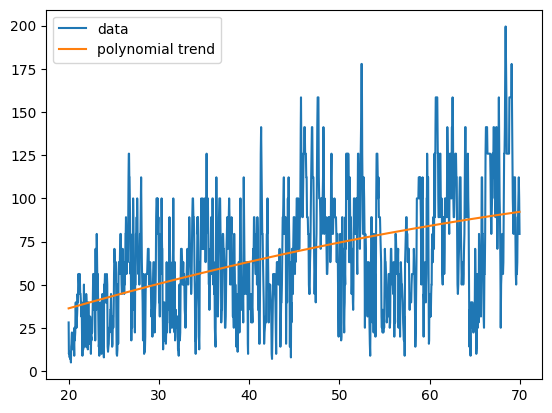

[67.58245051]


In [85]:
pf29 = PolynomialFeatures(degree=2)
Xp29 = pf29.fit_transform(x29-x0)
md29 = LinearRegression()

md29.fit(Xp29, y29)
trendp29 = md29.predict(Xp29)

mpl.plot(x29, y29)
mpl.plot(x29, trendp29)
mpl.legend(['data', 'polynomial trend'])
mpl.show()
print (md29.intercept_)

**PRN 5**

In [86]:
DF_GPSF5 = DF_GPSel.xs(5,level='PRN')
#print(DF_GPSF5)
DF_GPSazmax = DF_GPSF5['azsmth'].max()
DF_GPSazmin = DF_GPSF5['azsmth'].min()
print(DF_GPSazmin,',', DF_GPSazmax)

DF_GPSelmax = DF_GPSF5['elevsmth'].max()
DF_GPSelmin = DF_GPSF5['elevsmth'].min()
print(DF_GPSelmin,',', DF_GPSelmax)


DF_GPSFValue= DF_GPSF5.index.get_level_values('segment')
#print(DF_GPS5Value)
segment = []
for element in DF_GPSFValue:
    if element not in segment:
        segment.append(element)
print(segment)

44.014084507042256 , 71.95833333333333
20.00526315789474 , 22.0
[6, 7]


**PRN 5 segment 6**

In [87]:
GPSF_segment6_5=DF_GPSF5.xs(6,level='segment').reset_index()
print(GPSF_segment6_5['time'])

0     2022-03-26 13:58:18
1     2022-03-26 13:58:23
2     2022-03-26 13:58:28
3     2022-03-26 13:58:33
4     2022-03-26 13:58:38
              ...        
376   2022-03-26 14:29:38
377   2022-03-26 14:29:43
378   2022-03-26 14:29:48
379   2022-03-26 14:29:53
380   2022-03-26 14:29:58
Name: time, Length: 381, dtype: datetime64[ns]


**Mean**

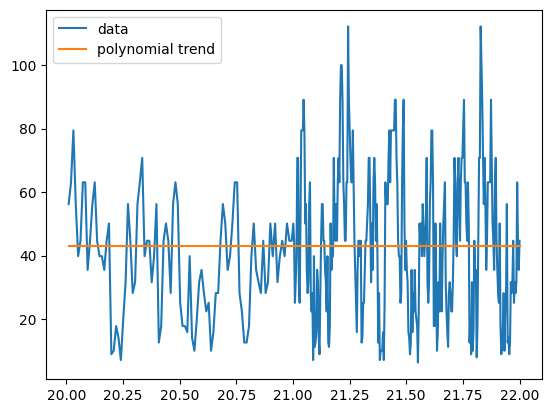

[43.02654992]


In [88]:
x5=GPSF_segment6_5[['elevsmth']].values
y5=GPSF_segment6_5[['snr']].values
y5=10**(y5/20)
x0=np.median(x5)

pf5 = PolynomialFeatures(degree=0)
Xp5 = pf5.fit_transform(x5)
md5 = LinearRegression()

md5.fit(Xp5, y5)
trendp5 = md5.predict(Xp5)

mpl.plot(x5, y5)
mpl.plot(x5, trendp5)
mpl.legend(['data', 'polynomial trend'])
mpl.show()
print (md5.intercept_)

**Polynomial**

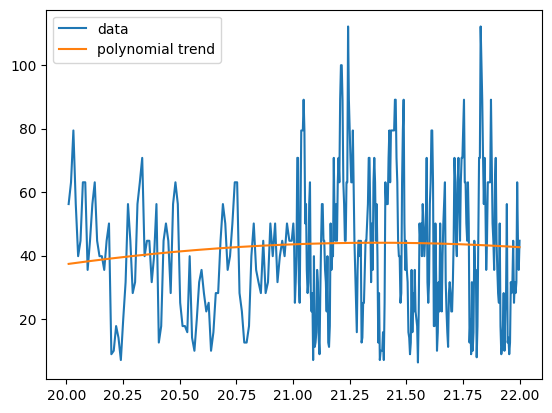

[44.04210492]


In [89]:
pf5 = PolynomialFeatures(degree=2)
Xp5 = pf5.fit_transform(x5-x0)
md5 = LinearRegression()

md5.fit(Xp5, y5)
trendp5 = md5.predict(Xp5)

mpl.plot(x5, y5)
mpl.plot(x5, trendp5)
mpl.legend(['data', 'polynomial trend'])
mpl.show()
print (md5.intercept_)

**PRN 5 Segment 7**

In [90]:
GPSF_segment7_5=DF_GPSF5.xs(7,level='segment').reset_index()
print(GPSF_segment7_5['time'])

0     2022-03-26 14:30:03
1     2022-03-26 14:30:08
2     2022-03-26 14:30:13
3     2022-03-26 14:30:18
4     2022-03-26 14:30:23
              ...        
363   2022-03-26 15:00:18
364   2022-03-26 15:00:23
365   2022-03-26 15:00:28
366   2022-03-26 15:00:33
367   2022-03-26 15:00:38
Name: time, Length: 368, dtype: datetime64[ns]


**Mean**

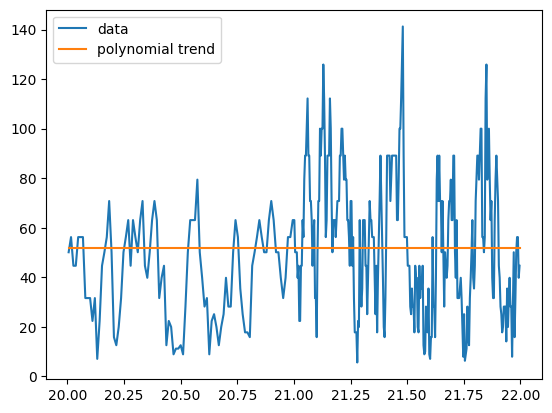

[51.80517486]


In [91]:
x5=GPSF_segment7_5[['elevsmth']].values
y5=GPSF_segment7_5[['snr']].values
y5=10**(y5/20)
x0=np.median(x5)

pf5 = PolynomialFeatures(degree=0)
Xp5 = pf5.fit_transform(x5)
md5 = LinearRegression()

md5.fit(Xp5, y5)
trendp5 = md5.predict(Xp5)

mpl.plot(x5, y5)
mpl.plot(x5, trendp5)
mpl.legend(['data', 'polynomial trend'])
mpl.show()
print (md5.intercept_)

**Polynomial**

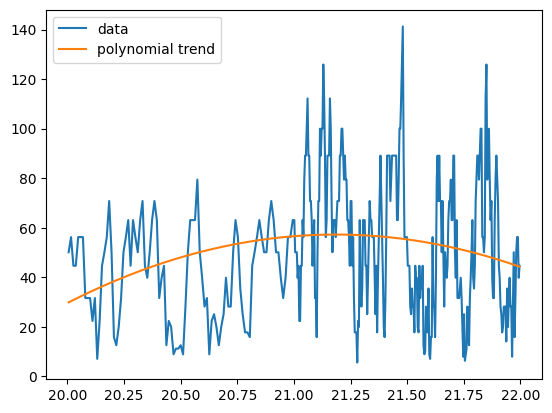

[56.87572465]


In [92]:
pf5 = PolynomialFeatures(degree=2)
Xp5 = pf5.fit_transform(x5-x0)
md5 = LinearRegression()

md5.fit(Xp5, y5)
trendp5 = md5.predict(Xp5)

mpl.plot(x5, y5)
mpl.plot(x5, trendp5)
mpl.legend(['data', 'polynomial trend'])
mpl.show()
print (md5.intercept_)

**PRN 18**

In [93]:
DF_GPSF18 = DF_GPSel.xs(18,level='PRN')
#print(DF_GPSF18)
DF_GPSazmax = DF_GPSF18['azsmth'].max()
DF_GPSazmin = DF_GPSF18['azsmth'].min()
print(DF_GPSazmin,',', DF_GPSazmax)

DF_GPSelmax = DF_GPSF18['elevsmth'].max()
DF_GPSelmin = DF_GPSF18['elevsmth'].min()
print(DF_GPSelmin,',', DF_GPSelmax)


DF_GPSFValue= DF_GPSF18.index.get_level_values('segment')
#print(DF_GPS5Value)
segment = []
for element in DF_GPSFValue:
    if element not in segment:
        segment.append(element)
print(segment)

60.0 , 119.875
20.04255319148936 , 69.99300699300699
[10, 11]


**PRN 18 Segment 10**

In [94]:
GPSF_segment10_18=DF_GPSF18.xs(10,level='segment').reset_index()
print(GPSF_segment10_18['time'])

0    2022-03-26 14:55:22
1    2022-03-26 14:55:27
2    2022-03-26 14:55:32
3    2022-03-26 14:55:37
4    2022-03-26 14:55:42
             ...        
73   2022-03-26 15:01:27
74   2022-03-26 15:01:32
75   2022-03-26 15:01:37
76   2022-03-26 15:01:42
77   2022-03-26 15:01:47
Name: time, Length: 78, dtype: datetime64[ns]


**Mean**

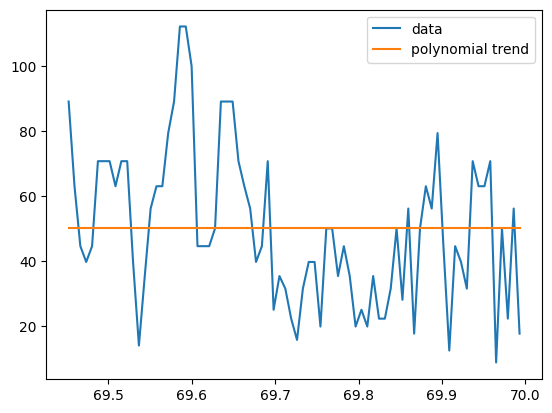

[50.15823281]


In [95]:
x18=GPSF_segment10_18[['elevsmth']].values
y18=GPSF_segment10_18[['snr']].values
y18=10**(y18/20)
x0=np.median(x18)

pf18 = PolynomialFeatures(degree=0)
Xp18 = pf18.fit_transform(x18)
md18 = LinearRegression()

md18.fit(Xp18, y18)
trendp18 = md18.predict(Xp18)

mpl.plot(x18, y18)
mpl.plot(x18, trendp18)
mpl.legend(['data', 'polynomial trend'])
mpl.show()
print (md18.intercept_)

**Polynomial**

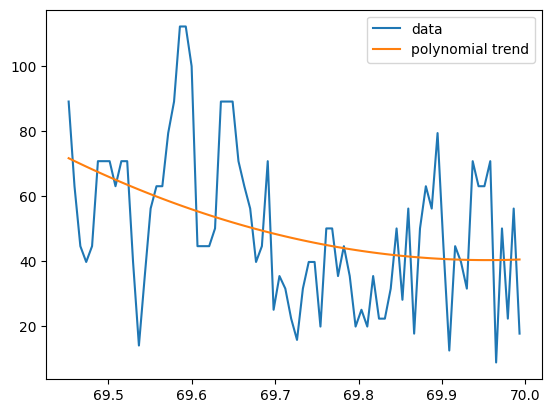

[47.05041491]


In [96]:
pf18 = PolynomialFeatures(degree=2)
Xp18 = pf18.fit_transform(x18-x0)
md18 = LinearRegression()

md18.fit(Xp18, y18)
trendp18 = md18.predict(Xp18)

mpl.plot(x18, y18)
mpl.plot(x18, trendp18)
mpl.legend(['data', 'polynomial trend'])
mpl.show()
print (md18.intercept_)

**PRN 18 Segment 11**

In [97]:
GPSF_segment11_18=DF_GPSF18.xs(11,level='segment').reset_index()
print(GPSF_segment11_18['time'])

0      2022-03-26 15:01:57
1      2022-03-26 15:02:02
2      2022-03-26 15:02:07
3      2022-03-26 15:02:12
4      2022-03-26 15:02:17
               ...        
1636   2022-03-26 17:18:18
1637   2022-03-26 17:18:23
1638   2022-03-26 17:18:28
1639   2022-03-26 17:18:33
1640   2022-03-26 17:18:38
Name: time, Length: 1641, dtype: datetime64[ns]


**Mean**

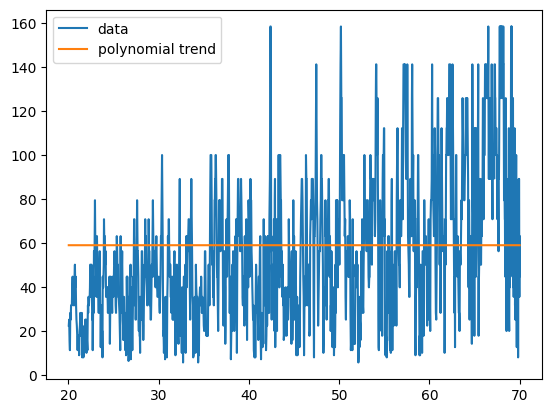

[58.97220939]


In [98]:
x18=GPSF_segment11_18[['elevsmth']].values
y18=GPSF_segment11_18[['snr']].values
y18=10**(y18/20)
x0=np.median(x18)

pf18 = PolynomialFeatures(degree=0)
Xp18 = pf18.fit_transform(x18)
md18 = LinearRegression()

md18.fit(Xp18, y18)
trendp18 = md18.predict(Xp18)

mpl.plot(x18, y18)
mpl.plot(x18, trendp18)
mpl.legend(['data', 'polynomial trend'])
mpl.show()
print (md18.intercept_)

**Polynomial**

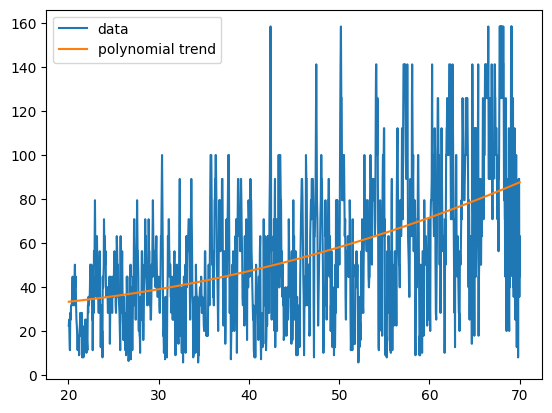

[56.86765418]


In [99]:
pf18 = PolynomialFeatures(degree=2)
Xp18 = pf18.fit_transform(x18-x0)
md18 = LinearRegression()

md18.fit(Xp18, y18)
trendp18 = md18.predict(Xp18)

mpl.plot(x18, y18)
mpl.plot(x18, trendp18)
mpl.legend(['data', 'polynomial trend'])
mpl.show()
print (md18.intercept_)

**PRN 23**

In [100]:
DF_GPSF23 = DF_GPSel.xs(23,level='PRN')
#print(DF_GPSF23)
DF_GPSazmax = DF_GPSF23['azsmth'].max()
DF_GPSazmin = DF_GPSF23['azsmth'].min()
print(DF_GPSazmin,',', DF_GPSazmax)

DF_GPSelmax = DF_GPSF23['elevsmth'].max()
DF_GPSelmin = DF_GPSF23['elevsmth'].min()
print(DF_GPSelmin,',', DF_GPSelmax)


DF_GPSFValue= DF_GPSF23.index.get_level_values('segment')
#print(DF_GPS23Value)
segment = []
for element in DF_GPSFValue:
    if element not in segment:
        segment.append(element)
print(segment)

47.84070796460177 , 119.95833333333333
20.014084507042252 , 50.0
[4, 5]


**PRN 23 Segment 4**

In [101]:
GPSF_segment4_23=DF_GPSF23.xs(4,level='segment').reset_index()
print(GPSF_segment4_23['time'])

0     2022-03-26 16:11:28
1     2022-03-26 16:11:33
2     2022-03-26 16:11:38
3     2022-03-26 16:11:43
4     2022-03-26 16:11:48
              ...        
576   2022-03-26 16:59:37
577   2022-03-26 16:59:42
578   2022-03-26 16:59:47
579   2022-03-26 16:59:52
580   2022-03-26 16:59:57
Name: time, Length: 581, dtype: datetime64[ns]


**Mean**

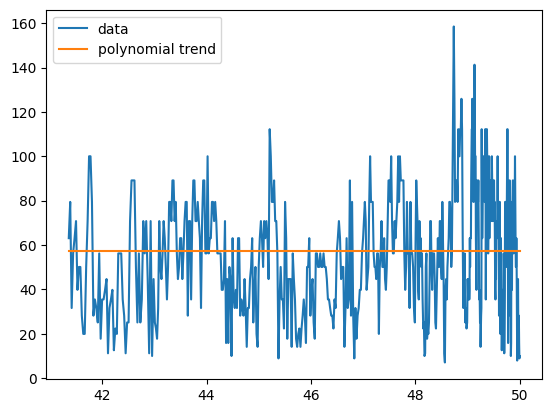

[57.25457268]


In [102]:
x23=GPSF_segment4_23[['elevsmth']].values
y23=GPSF_segment4_23[['snr']].values
y23=10**(y23/20)
x0=np.median(x23)

pf23 = PolynomialFeatures(degree=0)
Xp23 = pf23.fit_transform(x23)
md23 = LinearRegression()

md23.fit(Xp23, y23)
trendp23 = md23.predict(Xp23)

mpl.plot(x23, y23)
mpl.plot(x23, trendp23)
mpl.legend(['data', 'polynomial trend'])
mpl.show()
print (md23.intercept_)

**Polynomial**

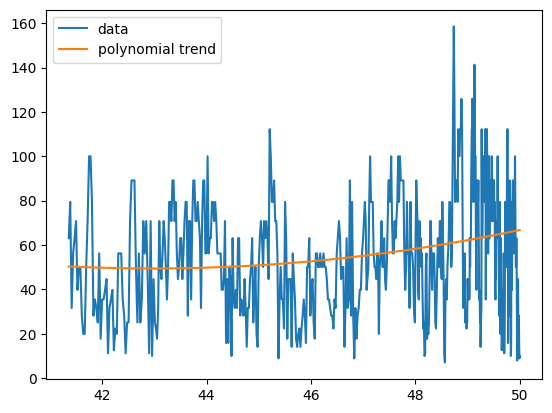

[57.24895534]


In [103]:
pf23 = PolynomialFeatures(degree=2)
Xp23 = pf23.fit_transform(x23-x0)
md23 = LinearRegression()

md23.fit(Xp23, y23)
trendp23 = md23.predict(Xp23)

mpl.plot(x23, y23)
mpl.plot(x23, trendp23)
mpl.legend(['data', 'polynomial trend'])
mpl.show()
print (md23.intercept_)

**PRN 23 Segment 5**

In [104]:
GPSF_segment5_23=DF_GPSF23.xs(5,level='segment').reset_index()
print(GPSF_segment5_23['time'])

0      2022-03-26 17:00:02
1      2022-03-26 17:00:07
2      2022-03-26 17:00:12
3      2022-03-26 17:00:17
4      2022-03-26 17:00:22
               ...        
1280   2022-03-26 18:46:43
1281   2022-03-26 18:46:48
1282   2022-03-26 18:46:53
1283   2022-03-26 18:46:58
1284   2022-03-26 18:47:03
Name: time, Length: 1285, dtype: datetime64[ns]


**Mean**

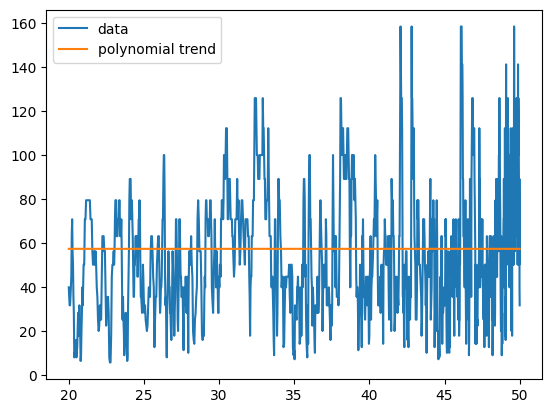

[57.32514002]


In [105]:
x23=GPSF_segment5_23[['elevsmth']].values
y23=GPSF_segment5_23[['snr']].values
y23=10**(y23/20)
x0=np.median(x23)

pf23 = PolynomialFeatures(degree=0)
Xp23 = pf23.fit_transform(x23)
md23 = LinearRegression()

md23.fit(Xp23, y23)
trendp23 = md23.predict(Xp23)

mpl.plot(x23, y23)
mpl.plot(x23, trendp23)
mpl.legend(['data', 'polynomial trend'])
mpl.show()
print (md23.intercept_)

**Polynomial**

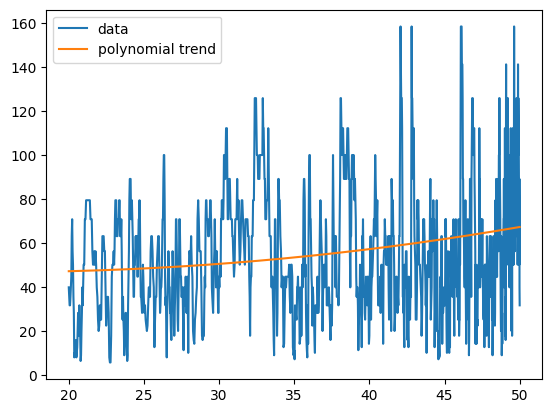

[57.18326277]


In [106]:
pf23 = PolynomialFeatures(degree=2)
Xp23 = pf23.fit_transform(x23-x0)
md23 = LinearRegression()

md23.fit(Xp23, y23)
trendp23 = md23.predict(Xp23)

mpl.plot(x23, y23)
mpl.plot(x23, trendp23)
mpl.legend(['data', 'polynomial trend'])
mpl.show()
print (md23.intercept_)

**PRN10**

In [107]:
DF_GPSF10 = DF_GPSel.xs(10,level='PRN')
#print(DF_GPSF10)
DF_GPSazmax = DF_GPSF10['azsmth'].max()
DF_GPSazmin = DF_GPSF10['azsmth'].min()
print(DF_GPSazmin,',', DF_GPSazmax)

DF_GPSelmax = DF_GPSF10['elevsmth'].max()
DF_GPSelmin = DF_GPSF10['elevsmth'].min()
print(DF_GPSelmin,',', DF_GPSelmax)


DF_GPSFValue= DF_GPSF10.index.get_level_values('segment')
#print(DF_GPS10Value)
segment = []
for element in DF_GPSFValue:
    if element not in segment:
        segment.append(element)
print(segment)

54.00200400801603 , 119.91666666666667
20.04255319148936 , 60.0
[6, 7]


**PRN 10 Segment 6**

In [108]:
GPSF_segment6_10=DF_GPSF10.xs(6,level='segment').reset_index()
print(GPSF_segment6_10['time'])

0     2022-03-26 17:36:32
1     2022-03-26 17:36:37
2     2022-03-26 17:36:42
3     2022-03-26 17:36:47
4     2022-03-26 17:36:52
              ...        
280   2022-03-26 17:59:57
281   2022-03-26 18:00:02
282   2022-03-26 18:00:07
283   2022-03-26 18:00:12
284   2022-03-26 18:00:17
Name: time, Length: 285, dtype: datetime64[ns]


**Mean**

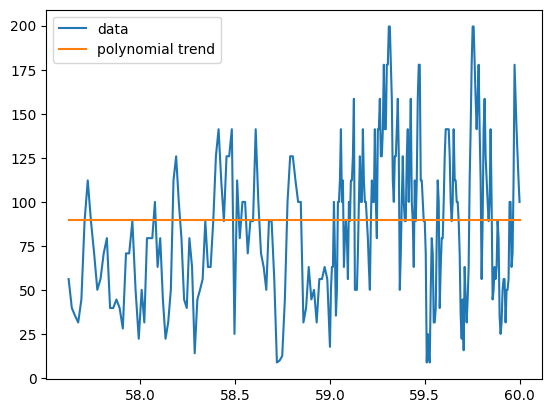

[89.57286422]


In [109]:
x10=GPSF_segment6_10[['elevsmth']].values
y10=GPSF_segment6_10[['snr']].values
y10=10**(y10/20)
x0=np.median(x10)

pf10 = PolynomialFeatures(degree=0)
Xp10 = pf10.fit_transform(x10)
md10 = LinearRegression()

md10.fit(Xp10, y10)
trendp10 = md10.predict(Xp10)

mpl.plot(x10, y10)
mpl.plot(x10, trendp10)
mpl.legend(['data', 'polynomial trend'])
mpl.show()
print (md10.intercept_)

**Polynomial**

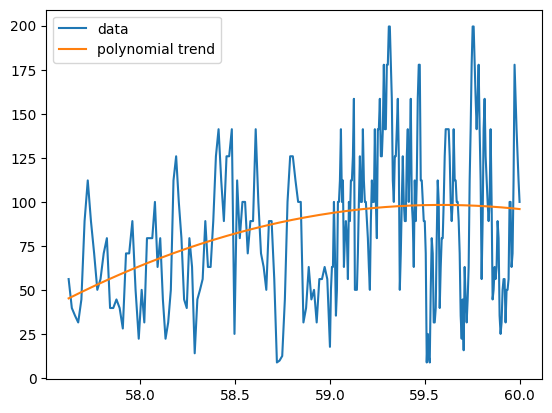

[96.75360073]


In [110]:
pf10 = PolynomialFeatures(degree=2)
Xp10 = pf10.fit_transform(x10-x0)
md10 = LinearRegression()

md10.fit(Xp10, y10)
trendp10 = md10.predict(Xp10)

mpl.plot(x10, y10)
mpl.plot(x10, trendp10)
mpl.legend(['data', 'polynomial trend'])
mpl.show()
print (md10.intercept_)

**PRN 10 Segment 7**

In [111]:
GPSF_segment7_10=DF_GPSF10.xs(7,level='segment').reset_index()
print(GPSF_segment7_10['time'])

0      2022-03-26 18:00:22
1      2022-03-26 18:00:27
2      2022-03-26 18:00:32
3      2022-03-26 18:00:37
4      2022-03-26 18:00:42
               ...        
1468   2022-03-26 20:02:48
1469   2022-03-26 20:02:53
1470   2022-03-26 20:02:58
1471   2022-03-26 20:03:03
1472   2022-03-26 20:03:08
Name: time, Length: 1473, dtype: datetime64[ns]


**Mean**

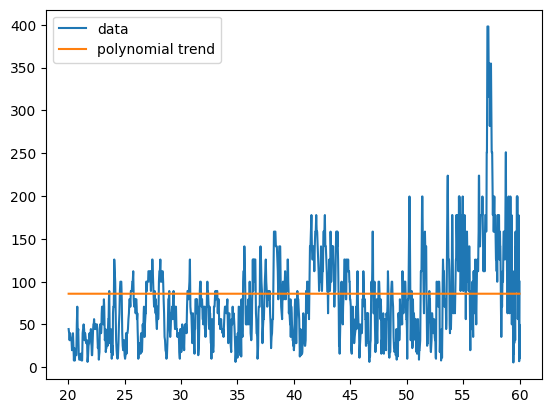

[85.93526755]


In [112]:
x10=GPSF_segment7_10[['elevsmth']].values
y10=GPSF_segment7_10[['snr']].values
y10=10**(y10/20)
x0=np.median(x10)

pf10 = PolynomialFeatures(degree=0)
Xp10 = pf10.fit_transform(x10)
md10 = LinearRegression()

md10.fit(Xp10, y10)
trendp10 = md10.predict(Xp10)

mpl.plot(x10, y10)
mpl.plot(x10, trendp10)
mpl.legend(['data', 'polynomial trend'])
mpl.show()
print (md10.intercept_)

**Polynomial**

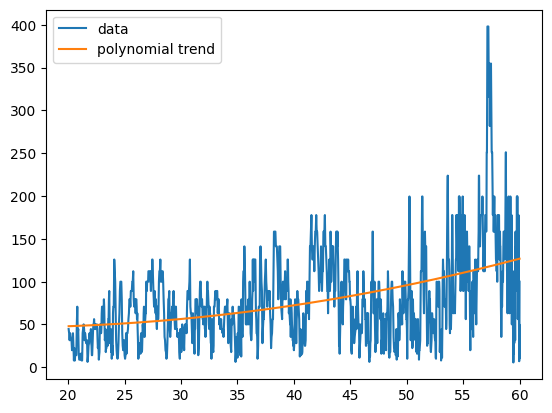

[83.18308262]


In [113]:
pf10 = PolynomialFeatures(degree=2)
Xp10 = pf10.fit_transform(x10-x0)
md10 = LinearRegression()

md10.fit(Xp10, y10)
trendp10 = md10.predict(Xp10)

mpl.plot(x10, y10)
mpl.plot(x10, trendp10)
mpl.legend(['data', 'polynomial trend'])
mpl.show()
print (md10.intercept_)

**PRN 32**

In [114]:
DF_GPSF32 = DF_GPSel.xs(32,level='PRN')
# print(DF_GPSF32)
DF_GPSazmax = DF_GPSF32['azsmth'].max()
DF_GPSazmin = DF_GPSF32['azsmth'].min()
print(DF_GPSazmin,',', DF_GPSazmax)

DF_GPSelmax = DF_GPSF32['elevsmth'].max()
DF_GPSelmin = DF_GPSF32['elevsmth'].min()
print(DF_GPSelmin,',', DF_GPSelmax)


DF_GPSFValue= DF_GPSF32.index.get_level_values('segment')
#print(DF_GPS10Value)
segment = []
for element in DF_GPSFValue:
    if element not in segment:
        segment.append(element)
print(segment)

43.7289156626506 , 119.97183098591549
20.028169014084508 , 40.99677419354839
[4, 5]


**PRN 32 Segment 4**

In [115]:
GPSF_segment4_32=DF_GPSF32.xs(4,level='segment').reset_index()
print(GPSF_segment4_32['time'])

0      2022-03-26 18:51:18
1      2022-03-26 18:51:23
2      2022-03-26 18:51:28
3      2022-03-26 18:51:33
4      2022-03-26 18:51:38
               ...        
1028   2022-03-26 20:17:07
1029   2022-03-26 20:17:12
1030   2022-03-26 20:17:17
1031   2022-03-26 20:17:22
1032   2022-03-26 20:17:27
Name: time, Length: 1033, dtype: datetime64[ns]


**Mean**

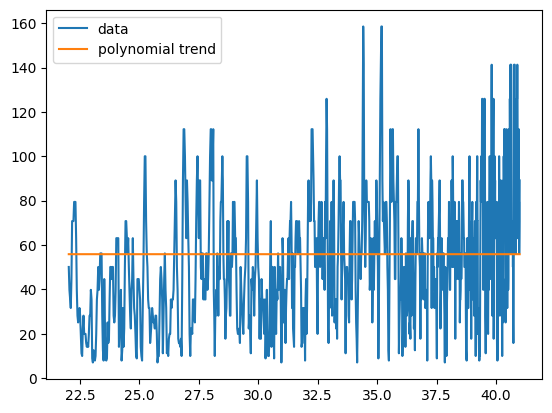

[55.87633148]


In [116]:
x32=GPSF_segment4_32[['elevsmth']].values
y32=GPSF_segment4_32[['snr']].values
y32=10**(y32/20)
x0=np.median(x32)

pf32 = PolynomialFeatures(degree=0)
Xp32 = pf32.fit_transform(x32)
md32 = LinearRegression()

md32.fit(Xp32, y32)
trendp32 = md32.predict(Xp32)

mpl.plot(x32, y32)
mpl.plot(x32, trendp32)
mpl.legend(['data', 'polynomial trend'])
mpl.show()
print (md32.intercept_)

**Polynomial**

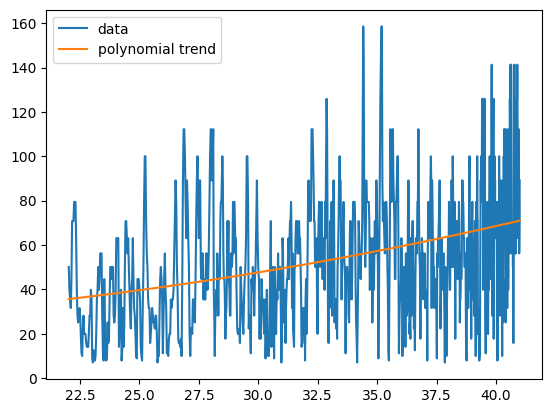

[57.08633921]


In [117]:
pf32 = PolynomialFeatures(degree=2)
Xp32 = pf32.fit_transform(x32-x0)
md32 = LinearRegression()

md32.fit(Xp32, y32)
trendp32 = md32.predict(Xp32)

mpl.plot(x32, y32)
mpl.plot(x32, trendp32)
mpl.legend(['data', 'polynomial trend'])
mpl.show()
print (md32.intercept_)

**PRN 32 Segment 5**

In [118]:
GPSF_segment5_32=DF_GPSF32.xs(5,level='segment').reset_index()
print(GPSF_segment5_32['time'])

0      2022-03-26 20:17:32
1      2022-03-26 20:17:37
2      2022-03-26 20:17:42
3      2022-03-26 20:17:47
4      2022-03-26 20:17:52
               ...        
1089   2022-03-26 21:48:18
1090   2022-03-26 21:48:23
1091   2022-03-26 21:48:28
1092   2022-03-26 21:48:33
1093   2022-03-26 21:48:38
Name: time, Length: 1094, dtype: datetime64[ns]


**Mean**

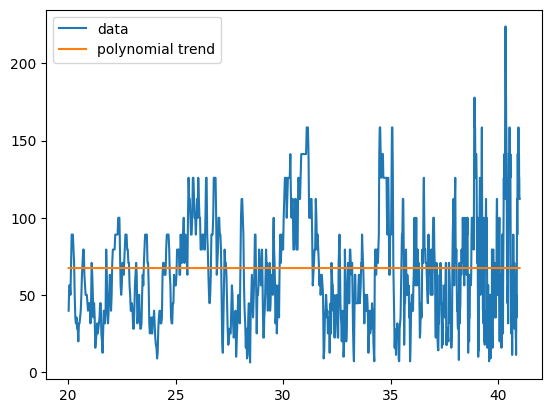

[67.45020531]


In [119]:
x32=GPSF_segment5_32[['elevsmth']].values
y32=GPSF_segment5_32[['snr']].values
y32=10**(y32/20)
x0=np.median(x32)

pf32 = PolynomialFeatures(degree=0)
Xp32 = pf32.fit_transform(x32)
md32 = LinearRegression()

md32.fit(Xp32, y32)
trendp32 = md32.predict(Xp32)

mpl.plot(x32, y32)
mpl.plot(x32, trendp32)
mpl.legend(['data', 'polynomial trend'])
mpl.show()
print (md32.intercept_)

**Polynomial**

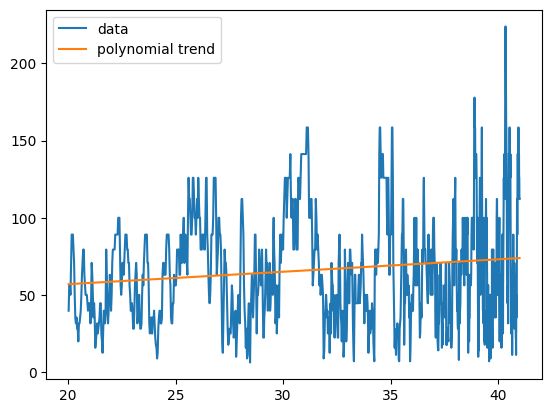

[68.4920437]


In [120]:
pf32 = PolynomialFeatures(degree=2)
Xp32 = pf32.fit_transform(x32-x0)
md32 = LinearRegression()

md32.fit(Xp32, y32)
trendp32 = md32.predict(Xp32)

mpl.plot(x32, y32)
mpl.plot(x32, trendp32)
mpl.legend(['data', 'polynomial trend'])
mpl.show()
print (md32.intercept_)

**PRN 22**

In [121]:
DF_GPSF22 = DF_GPSel.xs(22,level='PRN')
# print(DF_GPSF22)
DF_GPSazmax = DF_GPSF22['azsmth'].max()
DF_GPSazmin = DF_GPSF22['azsmth'].min()
print(DF_GPSazmin,',', DF_GPSazmax)

DF_GPSelmax = DF_GPSF22['elevsmth'].max()
DF_GPSelmin = DF_GPSF22['elevsmth'].min()
print(DF_GPSelmin,',', DF_GPSelmax)


DF_GPSFValue= DF_GPSF22.index.get_level_values('segment')
#print(DF_GPS22Value)
segment = []
for element in DF_GPSFValue:
    if element not in segment:
        segment.append(element)
print(segment)

45.33953488372093 , 119.97142857142858
20.014084507042252 , 43.99766355140187
[6, 7]


**PRN 22 Segment 6**

In [122]:
GPSF_segment6_22=DF_GPSF22.xs(6,level='segment').reset_index()
print(GPSF_segment6_22['time'])

0     2022-03-26 19:42:38
1     2022-03-26 19:42:43
2     2022-03-26 19:42:48
3     2022-03-26 19:42:53
4     2022-03-26 19:42:58
              ...        
875   2022-03-26 20:55:37
876   2022-03-26 20:55:42
877   2022-03-26 20:55:47
878   2022-03-26 20:55:52
879   2022-03-26 20:55:57
Name: time, Length: 880, dtype: datetime64[ns]


**Mean**

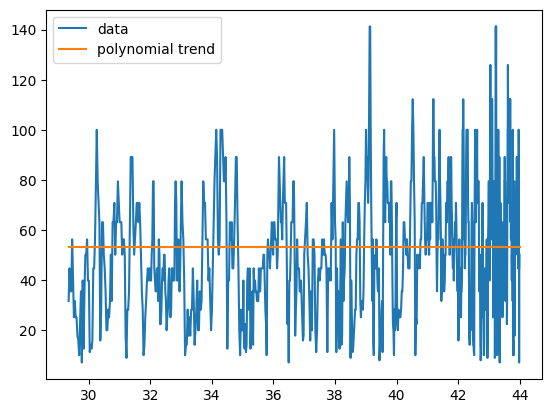

[53.35545958]


In [123]:
x22=GPSF_segment6_22[['elevsmth']].values
y22=GPSF_segment6_22[['snr']].values
y22=10**(y22/20)
x0=np.median(x22)

pf22 = PolynomialFeatures(degree=0)
Xp22 = pf22.fit_transform(x22)
md22 = LinearRegression()

md22.fit(Xp22, y22)
trendp22 = md22.predict(Xp22)

mpl.plot(x22, y22)
mpl.plot(x22, trendp22)
mpl.legend(['data', 'polynomial trend'])
mpl.show()
print (md22.intercept_)

**Polynomial**

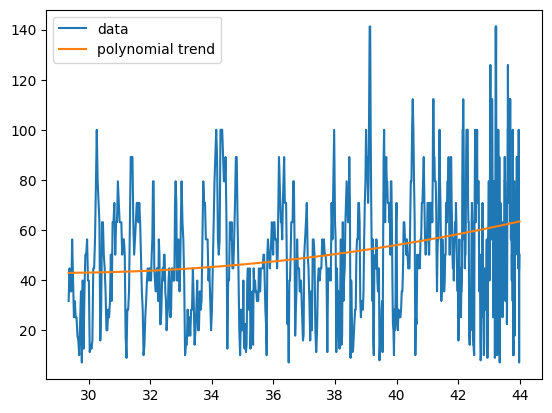

[53.58376999]


In [124]:
pf22 = PolynomialFeatures(degree=2)
Xp22 = pf22.fit_transform(x22-x0)
md22 = LinearRegression()

md22.fit(Xp22, y22)
trendp22 = md22.predict(Xp22)

mpl.plot(x22, y22)
mpl.plot(x22, trendp22)
mpl.legend(['data', 'polynomial trend'])
mpl.show()
print (md22.intercept_)

**PRN 22 Segment 7**

In [125]:
GPSF_segment7_22=DF_GPSF22.xs(7,level='segment').reset_index()
print(GPSF_segment7_22['time'])

0      2022-03-26 20:56:02
1      2022-03-26 20:56:07
2      2022-03-26 20:56:12
3      2022-03-26 20:56:17
4      2022-03-26 20:56:22
               ...        
1183   2022-03-26 22:34:48
1184   2022-03-26 22:34:53
1185   2022-03-26 22:34:58
1186   2022-03-26 22:35:03
1187   2022-03-26 22:35:08
Name: time, Length: 1188, dtype: datetime64[ns]


**Mean**

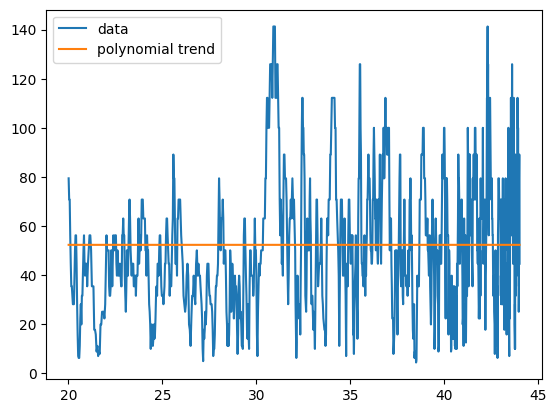

[52.35447125]


In [126]:
x22=GPSF_segment7_22[['elevsmth']].values
y22=GPSF_segment7_22[['snr']].values
y22=10**(y22/20)
x0=np.median(x22)

pf22 = PolynomialFeatures(degree=0)
Xp22 = pf22.fit_transform(x22)
md22 = LinearRegression()

md22.fit(Xp22, y22)
trendp22 = md22.predict(Xp22)

mpl.plot(x22, y22)
mpl.plot(x22, trendp22)
mpl.legend(['data', 'polynomial trend'])
mpl.show()
print (md22.intercept_)

**Polynomial**

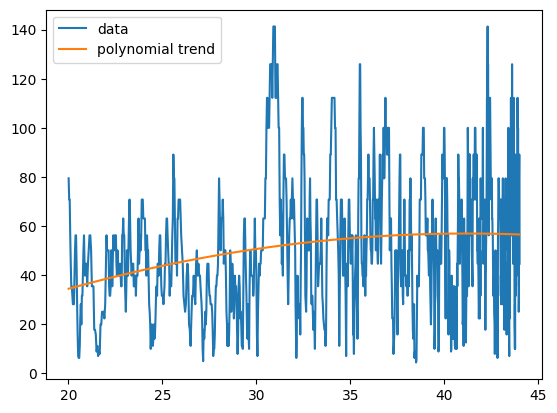

[55.84194161]


In [127]:
pf22 = PolynomialFeatures(degree=2)
Xp22 = pf22.fit_transform(x22-x0)
md22 = LinearRegression()

md22.fit(Xp22, y22)
trendp22 = md22.predict(Xp22)

mpl.plot(x22, y22)
mpl.plot(x22, trendp22)
mpl.legend(['data', 'polynomial trend'])
mpl.show()
print (md22.intercept_)

**PRN 21**

In [128]:
DF_GPSF21 = DF_GPSel.xs(21,level='PRN')
# print(DF_GPSF21)
DF_GPSazmax = DF_GPSF21['azsmth'].max()
DF_GPSazmin = DF_GPSF21['azsmth'].min()
print(DF_GPSazmin,',', DF_GPSazmax)

DF_GPSelmax = DF_GPSF21['elevsmth'].max()
DF_GPSelmin = DF_GPSF21['elevsmth'].min()
print(DF_GPSelmin,',', DF_GPSelmax)


DF_GPSFValue= DF_GPSF21.index.get_level_values('segment')
#print(DF_GPS21Value)
segment = []
for element in DF_GPSFValue:
    if element not in segment:
        segment.append(element)
print(segment)

109.02777777777777 , 119.97916666666667
55.541666666666664 , 69.95833333333333
[7]


**PRN 21 Segment 7**

In [129]:
GPSF_segment7_21=DF_GPSF21.xs(7,level='segment').reset_index()
print(GPSF_segment7_21['time'])

0     2022-03-26 20:45:07
1     2022-03-26 20:45:12
2     2022-03-26 20:45:17
3     2022-03-26 20:45:22
4     2022-03-26 20:45:27
              ...        
411   2022-03-26 21:19:22
412   2022-03-26 21:19:27
413   2022-03-26 21:19:32
414   2022-03-26 21:19:37
415   2022-03-26 21:19:42
Name: time, Length: 416, dtype: datetime64[ns]


**Mean**

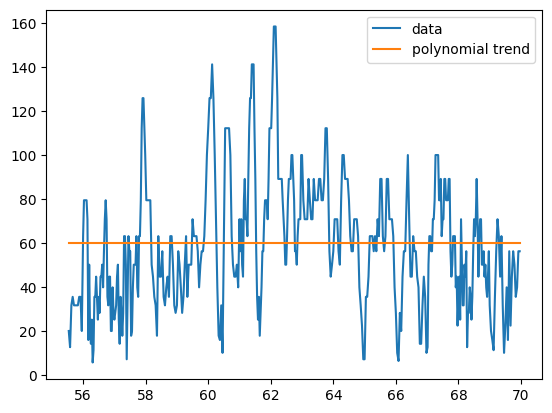

[60.18778551]


In [130]:
x21=GPSF_segment7_21[['elevsmth']].values
y21=GPSF_segment7_21[['snr']].values
y21=10**(y21/20)
x0=np.median(x21)

pf21 = PolynomialFeatures(degree=0)
Xp21 = pf21.fit_transform(x21)
md21 = LinearRegression()

md21.fit(Xp21, y21)
trendp21 = md21.predict(Xp21)

mpl.plot(x21, y21)
mpl.plot(x21, trendp21)
mpl.legend(['data', 'polynomial trend'])
mpl.show()
print (md21.intercept_)

**Polynomial**

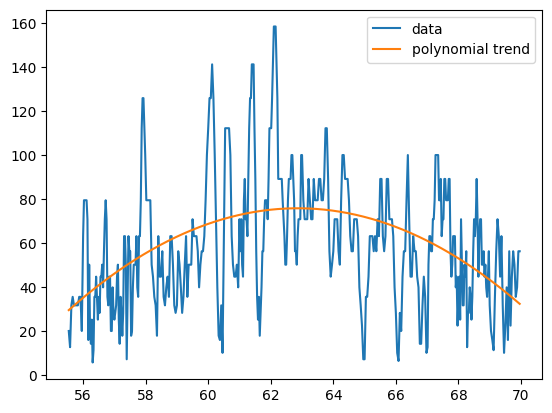

[75.67047686]


In [131]:
pf21 = PolynomialFeatures(degree=2)
Xp21 = pf21.fit_transform(x21-x0)
md21 = LinearRegression()

md21.fit(Xp21, y21)
trendp21 = md21.predict(Xp21)

mpl.plot(x21, y21)
mpl.plot(x21, trendp21)
mpl.legend(['data', 'polynomial trend'])
mpl.show()
print (md21.intercept_)

**PRN 31**

In [132]:
DF_GPSF31 = DF_GPSel.xs(31,level='PRN')
# print(DF_GPSF21)
DF_GPSazmax = DF_GPSF31['azsmth'].max()
DF_GPSazmin = DF_GPSF31['azsmth'].min()
print(DF_GPSazmin,',', DF_GPSazmax)

DF_GPSelmax = DF_GPSF31['elevsmth'].max()
DF_GPSelmin = DF_GPSF31['elevsmth'].min()
print(DF_GPSelmin,',', DF_GPSelmax)


DF_GPSFValue= DF_GPSF31.index.get_level_values('segment')
#print(DF_GPS31Value)
segment = []
for element in DF_GPSFValue:
    if element not in segment:
        segment.append(element)
print(segment)

43.361111111111114 , 77.32394366197182
20.006993006993007 , 23.99618320610687
[12, 13]


**PRN 31 Segment 12**

In [133]:
GPSF_segment12_31=DF_GPSF31.xs(12,level='segment').reset_index()
print(GPSF_segment12_31['time'])

0     2022-03-26 22:12:33
1     2022-03-26 22:12:38
2     2022-03-26 22:12:43
3     2022-03-26 22:12:48
4     2022-03-26 22:12:53
              ...        
460   2022-03-26 22:50:53
461   2022-03-26 22:50:58
462   2022-03-26 22:51:03
463   2022-03-26 22:51:08
464   2022-03-26 22:51:13
Name: time, Length: 465, dtype: datetime64[ns]


**Mean**

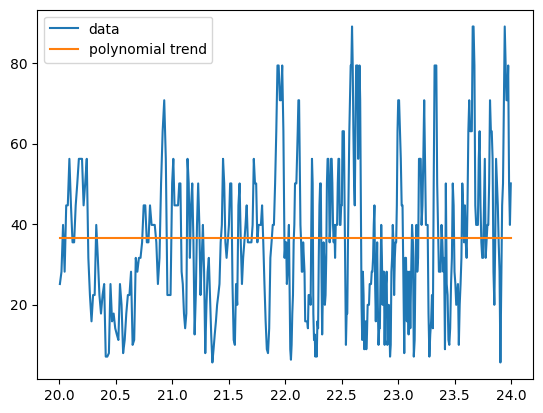

[36.62545183]


In [138]:
x31=GPSF_segment12_31[['elevsmth']].values
y31=GPSF_segment12_31[['snr']].values
y31=10**(y31/20)
x0=np.median(x31)

pf31 = PolynomialFeatures(degree=0)
Xp31 = pf31.fit_transform(x31)
md31 = LinearRegression()

md31.fit(Xp31, y31)
trendp31 = md31.predict(Xp31)

mpl.plot(x31, y31)
mpl.plot(x31, trendp31)
mpl.legend(['data', 'polynomial trend'])
mpl.show()
print (md31.intercept_)

**Polynomial**

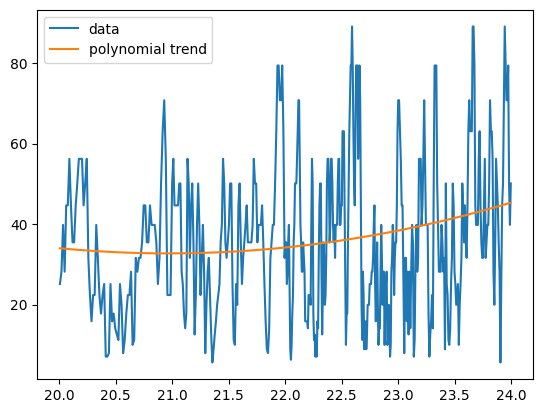

[35.52155405]


In [135]:
pf31 = PolynomialFeatures(degree=2)
Xp31 = pf31.fit_transform(x31-x0)
md31 = LinearRegression()

md31.fit(Xp31, y31)
trendp31 = md31.predict(Xp31)

mpl.plot(x31, y31)
mpl.plot(x31, trendp31)
mpl.legend(['data', 'polynomial trend'])
mpl.show()
print (md31.intercept_)

**PRN 31 Segment 13**

In [136]:
GPSF_segment13_31=DF_GPSF31.xs(13,level='segment').reset_index()
print(GPSF_segment13_31['time'])

0     2022-03-26 22:51:18
1     2022-03-26 22:51:23
2     2022-03-26 22:51:28
3     2022-03-26 22:51:33
4     2022-03-26 22:51:38
              ...        
445   2022-03-26 23:28:28
446   2022-03-26 23:28:33
447   2022-03-26 23:28:38
448   2022-03-26 23:28:43
449   2022-03-26 23:28:48
Name: time, Length: 450, dtype: datetime64[ns]


**Mean**

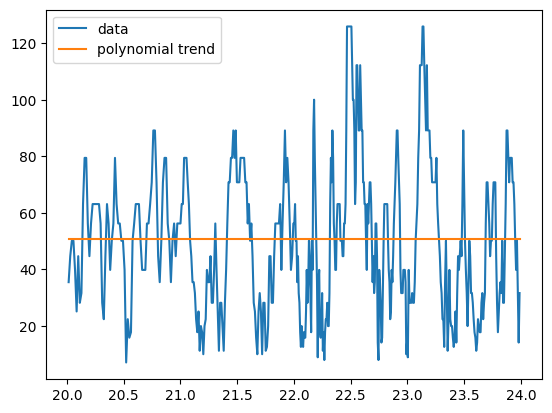

[50.57664892]


In [141]:
x31=GPSF_segment13_31[['elevsmth']].values
y31=GPSF_segment13_31[['snr']].values
y31=10**(y31/20)
x0=np.median(x31)

pf31 = PolynomialFeatures(degree=0)
Xp31 = pf31.fit_transform(x31)
md31 = LinearRegression()

md31.fit(Xp31, y31)
trendp31 = md31.predict(Xp31)

mpl.plot(x31, y31)
mpl.plot(x31, trendp31)
mpl.legend(['data', 'polynomial trend'])
mpl.show()
print (md31.intercept_)

**Polynomial**

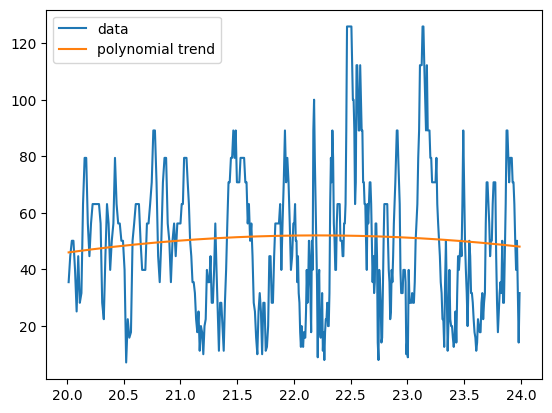

[51.97456727]


In [142]:
pf31 = PolynomialFeatures(degree=2)
Xp31 = pf31.fit_transform(x31-x0)
md31 = LinearRegression()

md31.fit(Xp31, y31)
trendp31 = md31.predict(Xp31)

mpl.plot(x31, y31)
mpl.plot(x31, trendp31)
mpl.legend(['data', 'polynomial trend'])
mpl.show()
print (md31.intercept_)

# SNR DIRECT SIGNALS REMOVED #